## 2) Exploratory Data Analysis (EDA)

**The table of contents**:
<br> - 2.1 Import libraries
<br> - 2.2 General Functions for EDA 
<br> - 2.3 Load /Investigate the *.csv Acting as Lookup Tables for Samples & Results Dataset
<br> - 2.4 Retrieve Dataset Sample and Results From SQL database
<br> - 2.5 First Analysis about Results Dataset
<br> - 2.6 First Analysis about Samples Dataset
<br> - 2.7 Merge Results and Samples dataset into sr dataset
>  2.7.1 Check Missmatches Between *.csv Dataset and main Dataset
<br> 2.7.2 Create `state_country_Name/Region` Columns Merging US State and Countries Based on Column `origin`
<br> 2.7.3 First Data Cleaning of sr Dataset

<br> - 2.8  Outliers Analysis
<br> - 2.9  Aggregated Data Countries/Pesticides/Fruits for Bar Plots Aalysis
<br> - 2.10 Time information 
<br> - 2.11 Feature Engineerings for Numerical/Non-Numerical Columns For Preparing ML:

>2.11.1 Remaining NANs values
<br> 2.11.2. First Drop of Useless Columns
<br> 2.11.3 Numerical Columns
<br> 2.11.4 Non Numerical Columns
<br> 2.11.5 Check Collinearities/Correlation Between Target and the Numerical Columns
<br> 2.11.6 Plots Features vs. Target 
<br> 2.11.7 Data Transformation for ML Models
<br> 2.11.8 Save Data as npz 


### 2.1. Import Libraries

In [1]:
# Import librairies
import os
import pandas as pd
import numpy as np
import sqlite3

from numpy import percentile
import random

#import plot librairies
import matplotlib.pyplot as plt
import seaborn as sns

#Release memory
import gc 

#table
from tabulate import tabulate

#Progression bar
from time import sleep
from tqdm import tqdm

In [2]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest,f_regression

In [3]:
# Take seaborn as preference graphic interface
#sns.set()

In [4]:
# Work on path_total for loading data
path_main = '/Users/jeromeaubry/Chap5.1-Proposal-Capstone/Data/'
path_secondary = 'US_Pesticide/2015PDPDatabase/Kaggle/'

path_total = os.path.join(path_main,path_secondary)
os.chdir(path_total)
os.getcwd()

'/Users/jeromeaubry/Chap5.1-Proposal-Capstone/Data/US_Pesticide/2015PDPDatabase/Kaggle'

### 2.2 General Functions for EDA 

In [5]:
'''
Display top values - frequencies, unique values,... from selected dataset df
''' 
def sortout_topvalues(df, N):
    
    col= [col for col in df.columns]

    # Create empty lists
    col_list =[]    
    nunique_list= []
    top_values = []
    frequencies = []

    with tqdm(total=100) as pbar:
        for c in col:
            col_list.append(c)
            nunique_list.append(df[c].nunique())
            top_values.append(list(pd.value_counts(df[c]).index[0:N]))
            frequencies.append(list(pd.value_counts(df[c]).values[0:N]))

            results = pd.DataFrame({'Feature_Nominal':col_list,
                          'N_unique_Nominal':nunique_list,
                          'Top_values_Nominal':top_values,
                          'Frequency_Nominal':frequencies})
            sleep(0.01)
            pbar.update(10)
        
    return results

In [6]:
'''
# Add column -col3- to the main database -df2- and rename it based on columns -col1, col2 - from 
the csv files -df1- acting as lookup tables
'''
def replaced_columns(df1, df2, col1, col2, col3):
    dict_df1 = {}
    dict_df1 =dict(zip(df1[col1], df1[col2]))
    col4 = col3 + ' Name'
    if col4 in df2:
        if (col4 == 'pestcode Name'):
            print(col4, 'already exists will be updated with', col4,  '2')
            col4 = col3 + ' Name2'
            df2[col4]= df2[col3].map(dict_df1)
        else:
            print('the column is already existing')
        pass
    else:    
        df2[col4]= df2[col3].map(dict_df1)
                                           
    return df2  

In [7]:
'''
Display statistic of the preselected dataframe
'''
def stat(df):
    
    df.info()

    print('-'*50)
    print('Number of Os:', df.isin([0]).sum().sum())
    print('-'*50)
    
    noNANs_df= (df.shape[0] - df.isna().sum()).to_frame()
    print(tabulate(noNANs_df, headers=['Column','no NANs']))
    print('-'*50)
    
    print('Number of NANs:',df.isna().sum().sum())
    print('-'*50)
    
    NANs_df = (100*df.isna().sum()/len(df)).to_frame().round(3)
    NANs_df.set_axis(['in %'],axis=1,inplace=True)
    
    print(tabulate(NANs_df.sort_values(by='in %', ascending=False).head(10), headers=['Column','NANs [%]']))
    print('-'*50)
    
    return df.describe()

In [8]:
'''
Resize the level of columns (multi-index) into one by flat index for multi-index dataset
'''
def flat_indexcolumns (df):
    results = [True if'_' in col else False for col in df.columns.get_level_values(0)]
    
    if results[0] == True: # Assume that all the column return same value; take the first one as reference
        return print('flat index already applied')
    else:
        df.columns = ['{}_{}'.format(level0, level1) for level0, level1 in df.columns.to_flat_index()] 
        
    return  df

In [9]:
'''
Function aggregating data via groupby function, gathering: count, sum, mean, std, min, max for 
the values in columns - col3 - and - col4 - for different input categorial columns -col1- , -col2-.
The associated values are plotted using unstack function from multi-index in barh and bar plot function.
For plotting the values the mean and std deviations are considered
'''

def groupby_plot(df, col1, col2, col3, col4):
    
    df_grouped = df.groupby([col1,col2]).agg({col3:['count','sum','mean','std', 'min', 'max'],
                                              col4:['count','sum','mean','std','min','max']})
    
    df_grouped = df_grouped.applymap(lambda x: round(x,4)) # take only 4 digits
    # Flatten the column index from multi-index
    df_grouped = flat_indexcolumns(df_grouped)
    col_group = df_grouped.columns
    
    # Mean values
    grouped_mean_col1 = df_grouped[col_group[2]].unstack(level=0) #mean col1
    grouped_std_col1 = df_grouped[col_group[3]].unstack(level=0)

    grouped_mean_col2 = df_grouped[col_group[8]].unstack(level=0) #mean col2
    grouped_mean_col2 = df_grouped[col_group[9]].unstack(level=0)


    #print(df_grouped.index.get_level_values(level=0))
    #print(df_grouped.index.get_level_values(level=1))
    #print(len(df_grouped.index.get_level_values(level=0)))
    #print(len(df_grouped.index.get_level_values(level=1)))

    fig, ax = plt.subplots(1,2, figsize=(20,12)) # width x height
    
    # Mean values col1 and col2 for main plot barh
    
    # col1 
    # Create artificial column sum for sorting out the values in ascending mode = False
    grouped_mean_col1['sum'] = grouped_mean_col1.sum(axis = 1)
    grouped_mean_col1 = grouped_mean_col1.sort_values(by='sum', ascending = True)
    grouped_mean_col1.loc[:,grouped_mean_col1.columns != 'sum'].plot.barh(stacked=True, ax=ax[0]) # don't plot sum
    ax[0].legend(loc='lower right')
    ax[0].set_xlabel(col_group[2])
    ax[0].set_title(col_group[2])

    # col2 using index col1 for reference purposes
    grouped_mean_col2 = grouped_mean_col2.loc[grouped_mean_col1.index,:]
    #grouped_mean_col2['sum'] = grouped_mean_col2.sum(axis = 1)
    #grouped_mean_col2 = grouped_mean_col2.sort_values(by='sum', ascending = True)
    #grouped_mean_col2.loc[:,grouped_mean_col2.columns != 'sum'].plot.barh(stacked=True, ax=ax[1]) # don't plot sum
    grouped_mean_col2.plot.barh(stacked=True, ax=ax[1], sharey=False)
    ax[1].legend(loc='lower right')
    ax[1].set_xlabel(col_group[8])
    ax[1].set_title(col_group[8])


    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()
    
    
    #Bases on the 3 most highest values, plot the y-x value in separated bar plots for mean +- std col1 and col2
    
    # Select the most 3 important values in y-axis
    N=3

    grouped_mean_col1_selected = df_grouped[col_group[2]].unstack(level=1).loc[:,grouped_mean_col1.index[-N:]] 
    grouped_std_col1_selected = df_grouped[col_group[3]].unstack(level=1).loc[:,grouped_mean_col1.index[-N:]] 
    # Reverse the column order
    grouped_mean_col1_selected = grouped_mean_col1_selected.iloc[:,::-1]
    grouped_std_col1_selected = grouped_std_col1_selected.iloc[:,::-1]

    # Reverse the plot x-y from above 
    grouped_mean_col2_selected = df_grouped[col_group[8]].unstack(level=1).loc[:,grouped_mean_col1.index[-N:]]
    grouped_std_col2_selected = df_grouped[col_group[9]].unstack(level=1).loc[:,grouped_mean_col1.index[-N:]]
    # Reverse the column order
    grouped_mean_col2_selected = grouped_mean_col2_selected.iloc[:,::-1]
    grouped_std_col2_selected = grouped_std_col2_selected.iloc[:,::-1]

    fig, ax = plt.subplots(N, 2, figsize=(20, 12))

    axes1 = [ax[0,0], ax[1,0], ax[2,0]] # column direction (0,0) (1,0)
    axes2 = [ax[0,1], ax[1,1], ax[2,1]] # row direction (0,1) (1,1)

    subplots_col1 = grouped_mean_col1_selected.plot(kind='bar', yerr=grouped_std_col1_selected, subplots=True, rot=90, sharex=True, sharey=False,
                            ax=axes1,layout=(N,2),legend=True,
                            align='center', alpha=0.5, ecolor='black', capsize=1, title=[col_group[2], col_group[2], col_group[2]])
    
   # List of subplots col1-col3
    for item in list(subplots_col1):
        if ((col3=='concen') & (col4=='lod')): # compare 'concen' and 'lod' data with same scale 
            item.set_ylim([0, 5*grouped_mean_col2_selected.iloc[:,0].max()]) #1st column
            item.set_ylabel(col3 + str( '[ppm]'))
        else:
            item.set_ylim([0, 5*grouped_mean_col1_selected.iloc[:,0].max()]) #1st column
            item.set_ylabel(col3)


    subplots_col2 = grouped_mean_col2_selected.plot(kind='bar', yerr=grouped_std_col2_selected, subplots=True, rot=90, sharex=True, sharey=False,
                           ax=axes2, layout=(N,2), legend=True,
                           align='center', alpha=0.5, ecolor='black', capsize=1, title=[col_group[8], col_group[8], col_group[8]])
    
    
    # List of subplots col2-col4
    for item in list(subplots_col2):
        item.set_ylim([0, 5*grouped_mean_col2_selected.iloc[:,0].max()])
        if (col4=='lod'):
            item.set_ylabel(col4 +  str( '[ppm]'))
        else:
            item.set_ylabel(col4)
    
    plt.subplots_adjust(wspace=0.2, hspace=0.2) 
    plt.show()

In [10]:
'''
Filling up the missing values by their associated frequency
Ref: https://stackoverflow.com/questions/57577188/replace-nan-values-by-user-defined-values-in-categorical-variables
'''
def replacedvalues_freq(df, col):
    
    count_vals = df[col].value_counts(normalize=True)  
    missing_vals = df[col].isnull()
    val = np.random.choice(count_vals.index, size=missing_vals.sum(), p=count_vals)

    df.loc[missing_vals, col] = val

    return df[col].value_counts(normalize=True)

In [11]:
'''
Define a function usinge selectkBest for down-select the most correlated columns approaching 'SalePrice'
Adapted from Q&As from project 3 
'''

def selected_bestcols(X,y,k):

    k = k
    skb = SelectKBest(f_regression, k=k)
    X_new = skb.fit_transform(X, y) 

    # Extract the top k features from the `pvalues_` attribute
    k_feat = np.argsort(skb.pvalues_)[:k]
    
    return k_feat 

### 2.3 Load /Investigate the csv Acting as Lookup Tables for Samples & Results Dataset

In [12]:
'''
Go through the list of *.csv files and sqlite files in the data directory
'''

files = []
files_pathname = 0

for dirpath, dirnames, filenames in os.walk(path_total):
    print('there are {} directories and {} files in {}'.format(len(dirnames), len(filenames), dirpath))
    files_pathname = files_pathname + len(filenames)
    for f in filenames:
        if (f.endswith('csv'))|(f.endswith('sqlite')):
            files.append(f)

print(files_pathname)

files=pd.DataFrame(files, columns=['File'])
files.sort_values(by='File',ascending='False').head()

there are 0 directories and 24 files in /Users/jeromeaubry/Chap5.1-Proposal-Capstone/Data/US_Pesticide/2015PDPDatabase/Kaggle/
24


,File
4,anotate_codes.csv
16,claim_codes.csv
21,commod_type_codes.csv
6,commodity_codes.csv
20,commodity_codes_extended.csv


In [13]:
'''
Load csv file, the file country_codes.csv has been extended with one column
displaying the classification of the country vs. region -America/Europ/Africa/Asian and rename as country_codes_extended.csv
In addition some references in 'country code' were missing, i.e. 160: Australia, 480: Italy, 630: Netherlands, 801: South Africa
By looking the ref number through others years in excel sheet from PPDB database, it was possible to retrieve the info.
Integrity of both dataset (Kaggle and PPDB) have been checked at the end of Annex II.
'''  
df_country = pd.read_csv('country_codes_extended.csv')
print(tabulate(df_country.info()))
df_country.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 3 columns):
Country Code    47 non-null object
Country Name    47 non-null object
Region Name     47 non-null object
dtypes: object(3)
memory usage: 1.2+ KB



,Country Code,Country Name,Region Name
0,150,Argentina,America (wo US)
1,160,Australia,Ocenania
2,190,Belgium,Europe
3,260,Canada,America (wo US)
4,275,Chile,America (wo US)


In [14]:
# Create a dictonnary to link with the 'Country Code' with 'Country Name'
dict_country = {}
dict_country =dict(zip(df_country['Country Code'], df_country['Country Name']))
dict_country

{'150': 'Argentina',
 '160': 'Australia',
 '190': 'Belgium',
 '260': 'Canada',
 '275': 'Chile',
 '280': 'China',
 '285': 'Colombia',
 '295': 'Costa Rica',
 '315': 'Denmark',
 '320': 'Dominican Republic',
 '325': 'Ecuador',
 '350': 'France',
 '400': 'Greece',
 '415': 'Guatemala',
 '430': 'Honduras',
 '455': 'India',
 '470': 'Ireland',
 '475': 'Israel',
 '480': 'Italy',
 '595': 'Mexico',
 '630': 'Netherlands',
 '660': 'New Zealand',
 '665': 'Nicaragua',
 '685': 'Norway',
 '700': 'Pakistan',
 '720': 'Peru',
 '801': 'South Africa',
 '825': 'Russia',
 '875': 'Thailand',
 '905': 'Turkey',
 '922': 'Egypt',
 '925': 'United Kingdom',
 '930': 'Uruguay',
 '945': 'Vietnam',
 'M06': 'Mexico / USA',
 'M15': 'China / USA',
 'M35': 'Argentina / USA',
 'M42': 'Argentina / Brazil',
 'M66': 'Argentina / Chile / USA',
 'MA6': 'Canada / USA',
 'MJ1': 'Argentina / Mexico / USA',
 'MJ8': 'China / Russia',
 'MK2': 'Argentina / China / Thailand / Uruguay / Vietnam / USA',
 'MK3': 'Chile / Turkey / USA',
 'MK4'

In [15]:
# Create a dictonnary to link with the 'Country Name' with 'Region Name'
dict_region = dict_country =dict(zip(df_country['Country Name'], df_country['Region Name']))
dict_region

{'Argentina': 'America (wo US)',
 'Australia': 'Ocenania',
 'Belgium': 'Europe',
 'Canada': 'America (wo US)',
 'Chile': 'America (wo US)',
 'China': 'Asian',
 'Colombia': 'America (wo US)',
 'Costa Rica': 'America (wo US)',
 'Denmark': 'Europe',
 'Dominican Republic': 'America (wo US)',
 'Ecuador': 'America (wo US)',
 'France': 'Europe',
 'Greece': 'Europe',
 'Guatemala': 'America (wo US)',
 'Honduras': 'America (wo US)',
 'India': 'Asian',
 'Ireland': 'Europe',
 'Israel': 'Asian',
 'Italy': 'Europe',
 'Mexico': 'America (wo US)',
 'Netherlands': 'Europe',
 'New Zealand': 'Ocenania',
 'Nicaragua': 'America (wo US)',
 'Norway': 'Europe',
 'Pakistan': 'Asian',
 'Peru': 'America (wo US)',
 'South Africa': 'Africa',
 'Russia': 'Asian',
 'Thailand': 'Asian',
 'Turkey': 'Asian',
 'Egypt': 'Africa',
 'United Kingdom': 'Europe',
 'Uruguay': 'America (wo US)',
 'Vietnam': 'Asian',
 'Mexico / USA': 'America (wo US)',
 'China / USA': 'Asian',
 'Argentina / USA': 'America (wo US)',
 'Argentina / 

In [16]:
'''
Load csv file, the file state_codes.csv has been extended with one column
displaying the classification of the US state vs.region -East/Central/West and rename 
as state_codes_extended.csv
''' 
df_state = pd.read_csv('state_codes_extended.csv')
print(df_state.info())
df_state.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
State Code    52 non-null object
State         52 non-null object
US Region     52 non-null object
dtypes: object(3)
memory usage: 1.3+ KB
None


,State Code,State,US Region
0,AK,Alaska,US_West
1,AL,Alabama,US_East
2,AR,Arkansas,US_Central
3,AZ,Arizona,US_West
4,CA,California,US_West


In [17]:
# Load csv file
df_tolerance = pd.read_csv('tolerance_codes.csv')
print(df_tolerance.info())
df_tolerance.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6474 entries, 0 to 6473
Data columns (total 6 columns):
Pesticide Code         6474 non-null object
Commodity Code         6474 non-null object
EPA Tolerance Value    6332 non-null object
pp_                    6456 non-null object
Note                   350 non-null object
Comment                928 non-null object
dtypes: object(6)
memory usage: 303.5+ KB
None


,Pesticide Code,Commodity Code,EPA Tolerance Value,pp_,Note,Comment
0,001,AP,0.03,M,AL,Action Level
1,001,BB,0.05,M,AL,Action Level
2,001,BN,0.02,M,AL,Action Level
3,001,BR,0.03,M,AL,Action Level
4,001,BZ,0.05,M,AL,Action Level


In [18]:
#  Load csv file for the pesticide names and codes
'''
Load csv file, the file pest_codes.csv gathering > 400 pesticide codes.
The file has been extended and took from PPDB database 2015 and 
rename pest_codes_extended.csv since the csv file from Kaggle display discrepencies 
'''  

df_pestcodes = pd.read_csv('pest_codes_extended.csv') # Info from the PPDB database
df_pestcodes2 = pd.read_csv('pest_codes.csv') # Info from the present kaggle database


print(df_pestcodes.info())
print(df_pestcodes2.info())
df_pestcodes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 4 columns):
Pest Code                495 non-null object
Pesticide Name           495 non-null object
Test Class               495 non-null object
# of Analysis Results    494 non-null float64
dtypes: float64(1), object(3)
memory usage: 15.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 4 columns):
Pest Code                484 non-null object
Pesticide Name           484 non-null object
Test Class               484 non-null object
# of Analysis Results    484 non-null int64
dtypes: int64(1), object(3)
memory usage: 15.2+ KB
None


,Pest Code,Pesticide Name,Test Class,# of Analysis Results
0,001,Aldrin,A,10187.0
1,002,Allethrin,O,5938.0
2,007,Biphenyl,I,349.0
3,011,Captan,A,3175.0
4,014,Chlordanes Total,A,1728.0


In [19]:
# Cross check the 2 dataset
df_pestcodes.equals(df_pestcodes2)

False

In [20]:
# Merge for plotting them 
merged_pestcodes =  df_pestcodes.merge(df_pestcodes2,on='Pest Code')
merged_pestcodes.head()

,Pest Code,Pesticide Name_x,Test Class_x,# of Analysis Results_x,Pesticide Name_y,Test Class_y,# of Analysis Results_y
0,001,Aldrin,A,10187.0,Aldrin,A,10150
1,002,Allethrin,O,5938.0,Allethrin,O,6718
2,011,Captan,A,3175.0,Captan,A,2903
3,014,Chlordanes Total,A,1728.0,Chlordanes Total,A,1389
4,015,Chlorobenzilate,A,1644.0,Chlorobenzilate,A,1770


In [21]:
print('level of correlation between dataset kaggle and PPDB for the analysis results: {:.2f}%'.format(100*
    merged_pestcodes['# of Analysis Results_x'].corr(merged_pestcodes['# of Analysis Results_y'])))

level of correlation between dataset kaggle and PPDB for the analysis results: 86.56%


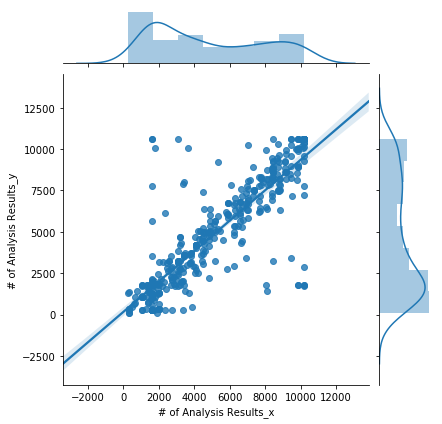

In [22]:
sns.jointplot(data=merged_pestcodes,
              x= merged_pestcodes['# of Analysis Results_x'],
              y= merged_pestcodes['# of Analysis Results_y'],
              kind='reg',
             )
plt.show()

In [23]:
print(len(df_pestcodes))
print(len(df_pestcodes2))

df_diff = pd.concat([df_pestcodes['Pest Code'],df_pestcodes2['Pest Code']]).drop_duplicates(keep=False)
print(len(df_diff))
print(df_diff)

495
484
11
2      007
33     111
97     229
162    587
235    786
318    ACF
433    AMH
439    AMR
440    AMS
448    ANE
449    ANF
Name: Pest Code, dtype: object


> **Remarks**:
<br> - They are 495 different pesticides classified into 20 codes and the 11 different pesticides are listed between both dataset.
<br> - As noticed previously for the country file, the csv file displays some missmatches and it has been decided to replace the csv file by the one from the PPDB database and rename as 'pest_codes_extended.csv'.

In [24]:
#  Load csv file
df_testclasscodes = pd.read_csv('test_class_codes.csv') 
print(tabulate(df_testclasscodes.info()))
df_testclasscodes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
Test Class Code          20 non-null object
Test (Compound) Class    20 non-null object
dtypes: object(2)
memory usage: 400.0+ bytes



,Test Class Code,Test (Compound) Class
0,A,Halogenated
1,B,Benzimidazole
2,C,Organophosphorus
3,D,Avermectin
4,E,Carbamate


In [25]:
#  Add column in csv file by using replaced_columns function
df_pestcodes = replaced_columns(df_testclasscodes, df_pestcodes, 'Test Class Code', 'Test (Compound) Class', 'Test Class')
df_pestcodes.head()

,Pest Code,Pesticide Name,Test Class,# of Analysis Results,Test Class Name
0,001,Aldrin,A,10187.0,Halogenated
1,002,Allethrin,O,5938.0,Pyrethroids
2,007,Biphenyl,I,349.0,Other Compounds
3,011,Captan,A,3175.0,Halogenated
4,014,Chlordanes Total,A,1728.0,Halogenated


In [26]:
df_pestcodes.head()

,Pest Code,Pesticide Name,Test Class,# of Analysis Results,Test Class Name
0,001,Aldrin,A,10187.0,Halogenated
1,002,Allethrin,O,5938.0,Pyrethroids
2,007,Biphenyl,I,349.0,Other Compounds
3,011,Captan,A,3175.0,Halogenated
4,014,Chlordanes Total,A,1728.0,Halogenated


In [27]:
# Groupby pesticides codes and aggregate the sum, counts, mean, min, max values
df_pestcodes_grouped = df_pestcodes.groupby(['Test Class Name']).agg({'# of Analysis Results': ['count', 'sum', 'mean', 'std', 'min', 'max'] })
df_pestcodes_grouped = df_pestcodes_grouped.applymap(lambda x: round(x, 2)) #Consider 2 digits 

# Flatten the multi-index columns for easiest manipulations
flat_indexcolumns(df_pestcodes_grouped)
df_pestcodes_grouped.round(1)
df_pestcodes_grouped=df_pestcodes_grouped.reset_index()
df_pestcodes_grouped.head()

,Test Class Name,# of Analysis Results_count,# of Analysis Results_sum,# of Analysis Results_mean,# of Analysis Results_std,# of Analysis Results_min,# of Analysis Results_max
0,"2,4-D / Acid Herbicides",19,35321.0,1859.00,696.16,1456.0,4527.0
1,Avermectin,4,9107.0,2276.75,1620.06,315.0,3934.0
2,Benzimidazole,3,27664.0,9221.33,911.48,8376.0,10187.0
3,Carbamate,40,165740.0,4143.50,3315.00,87.0,10187.0
4,Conazoles / Triazoles,24,134983.0,5624.29,2982.02,1494.0,10187.0


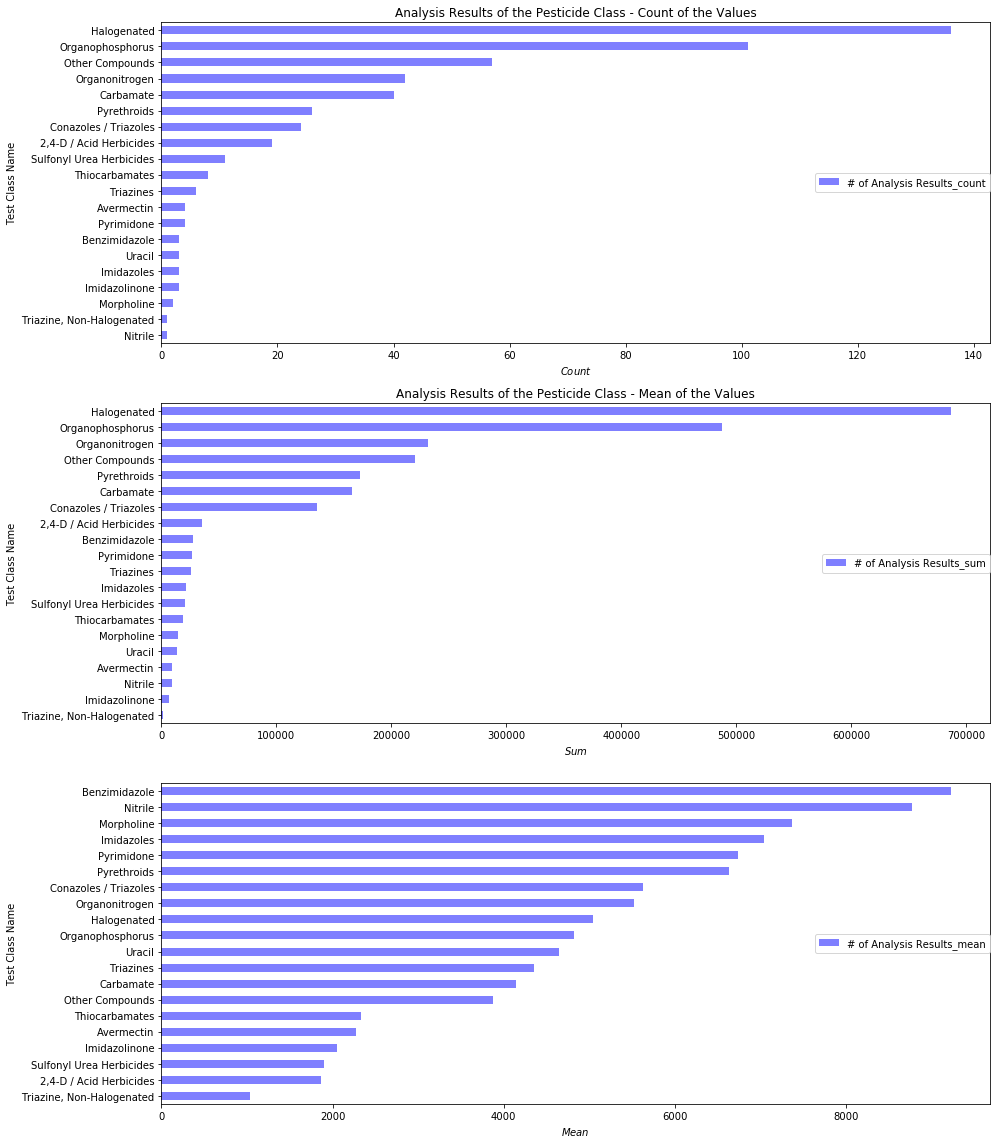

In [28]:
# Plots the count, sum, and mean results for the pestcodes 
fig, ax = plt.subplots(3,1)

colormap = plt.cm.tab20(range(0, len(df_pestcodes_grouped)))
#Count
df_pestcodes_grouped_plot = df_pestcodes_grouped.sort_values(by='# of Analysis Results_count', ascending=True)
df_pestcodes_grouped_plot = df_pestcodes_grouped_plot.plot.barh(x='Test Class Name', y='# of Analysis Results_count',color='b',alpha=0.5, 
                                                                figsize=(14,16), ax=ax[0])
ax[0].set_title('Analysis Results of the Pesticide Class - Count of the Values')
ax[0].legend(loc=7,borderaxespad=0)
ax[0].set_xlabel('$Count$')
#Sum
df_pestcodes_grouped_plot = df_pestcodes_grouped.sort_values(by='# of Analysis Results_sum', ascending=True)
df_pestcodes_grouped_plot = df_pestcodes_grouped_plot.plot.barh(x='Test Class Name', y='# of Analysis Results_sum',color='b', alpha=0.5, 
                                                                figsize=(14,16), ax=ax[1])
ax[1].set_title('Analysis Results of the Pesticide Class - Sum of the Values')
ax[1].legend(loc=7,borderaxespad=0)
ax[1].set_xlabel('$Sum$')

#Mean
df_pestcodes_grouped_plot = df_pestcodes_grouped.sort_values(by='# of Analysis Results_mean', ascending=True)
df_pestcodes_grouped_plot = df_pestcodes_grouped_plot.plot.barh(x='Test Class Name', y='# of Analysis Results_mean',color='b', alpha=0.5, 
                                                                figsize=(14,16), ax=ax[2])
ax[1].set_title('Analysis Results of the Pesticide Class - Mean of the Values')
ax[2].legend(loc=7,borderaxespad=0)
ax[2].set_xlabel('$Mean$')

fig.tight_layout()
plt.show()

> Remark: 
<br> - From the mean values the analyzed pesticide class `Nitrile`, `Pyrethroids` are overrepresented by a factor 6-7 bigger than the pesticides `Sulfonyl Urea Herbicides` and `Triazine, Non-Halogenated` for example.

In [29]:
'''
The file 'commodity_code.csv' embedded with the project kaggle is wrong and does not fit the data
for tackling the issue, the data from the excel sheet provided by the PPDB database 2015 has been taken and replaced accordingly
and rename as commodity_code_extended.csv
Integrity of both dataset (Kaggle and PPDB) have been checked at the end of Annex II
'''
#excel_file = os.path.join(main_path_excel,sec_path_excel)
#print(excel_file)
#df_com_codes = pd.read_excel(excel_file, sheet_name='Commodity', header=4)
#df_com_codes = pd.read_csv('commodity_codes.csv')

df_com_codes = pd.read_csv('commodity_codes_extended.csv')
df_com_codes.head()

,Commodity Code,Commodity Name,# of Samples Analyzed
0,AP,Apples,708
1,CB,"Sweet Corn, Fresh",468
2,CH,Cherries,232
3,CS,"Sweet Corn, Frozen",65
4,CU,Cucumbers,378


In [30]:
# Groupby name of crops and aggregate the sum, counts, mean values
df_com_codes_grouped = df_com_codes.groupby(['Commodity Name']).agg({'# of Samples Analyzed':['count', 'sum']})
# Flatten the multi-index columns for easiest manipulations
flat_indexcolumns(df_com_codes_grouped)

df_com_codes_grouped = df_com_codes_grouped.reset_index()
df_com_codes_grouped.head()

,Commodity Name,# of Samples Analyzed_count,# of Samples Analyzed_sum
0,Apples,1,708
1,Cherries,1,232
2,"Cherries, Frozen",1,453
3,Cucumbers,1,378
4,Grapefruit,1,177


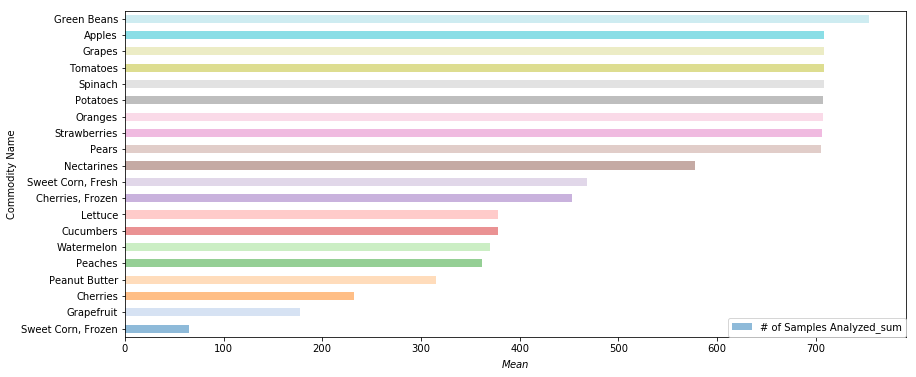

In [31]:
# Plots the sum of the sample analysed for vegetables/fruits.

colormap = plt.cm.tab20(range(0, len(df_pestcodes_grouped)))

#Sum 
#count =1, therefore sum = mean
df_com_codes_grouped = df_com_codes_grouped.sort_values(by=['# of Samples Analyzed_sum'], ascending=True)
df_com_codes_grouped.plot.barh(x='Commodity Name', y='# of Samples Analyzed_sum',color=colormap, alpha=0.5,figsize=(14,6))
plt.legend(loc=0,borderaxespad=0)
plt.xlabel('$Mean$')

plt.show()

> **Remark**:
<br> - We see an unven distribution of the number of sample analysed for the fruits/vegetables, by a factor 7 between the most represented suchs as `Green Beans`  and the least one `Sweet Corn, Frozen`. 

In [32]:
df_com_types = pd.read_csv('commod_type_codes.csv')
df_com_types

,Commod Type Code,Commodity Type
0,BR,Bran
1,CA,Canned
2,CO,Liquid Concentrate
3,FR,Fresh
4,FZ,Frozen
5,GR,"Grain, Raw"
6,PD,Powdered
7,RE,Liquid Ready-to-Serve
8,RO,Rolled
9,SC,Steel-Cut (grain)


### 2.4 Retrieve Dataset Sample and Results From SQL database

In [33]:
# Retrieve the name of the tables in the *.sqlite format
db = sqlite3.connect('database.sqlite')
cursor = db.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [row for row in cursor.fetchall()] 
cursor.close()
print('tables=',tables)

tables= [('sampledata15',), ('resultsdata15',)]


In [34]:
# Retrieve the tables
db = sqlite3.connect('database.sqlite')
cursor = db.cursor()
results= pd.read_sql_query('SELECT * from resultsdata15',db)
samples= pd.read_sql_query('SELECT * from sampledata15',db)

db.close()

### 2.5 First Analysis about Results Dataset

In [35]:
results.head()

,sample_pk,commod,commtype,lab,pestcode,testclass,concen,lod,conunit,confmethod,confmethod2,annotate,quantitate,mean,extract,determin
0,2,AP,FR,WA1,382,E,,0.015,M,,,,,ND,805,35\r\n
1,2,AP,FR,WA1,387,A,,0.005,M,,,,,ND,805,35\r\n
2,2,AP,FR,WA1,388,A,,0.005,M,,,,,ND,805,35\r\n
3,2,AP,FR,WA1,512,E,,0.003,M,,,,,ND,805,52\r\n
4,2,AP,FR,WA1,529,A,,0.010,M,,,,,ND,805,35\r\n


In [36]:
results.columns

Index(['sample_pk', 'commod', 'commtype', 'lab', 'pestcode', 'testclass',
       'concen', 'lod', 'conunit', 'confmethod', 'confmethod2', 'annotate',
       'quantitate', 'mean', 'extract', 'determin'],
      dtype='object')

In [37]:
# Sort out the 10 most frequent values from the database 'results' 
sortout_topvalues(results, 10)

160it [00:09, 16.26it/s]                         


,Feature_Nominal,N_unique_Nominal,Top_values_Nominal,Frequency_Nominal
0,sample_pk,10187,"[8651, 9109, 8711, 8657, 9104, 8880, 9105, 910...","[425, 425, 425, 425, 425, 425, 425, 425, 425, ..."
1,commod,20,"[ST, NE, AP, SP, OG, CB, TO, PO, GB, GR]","[298247, 243049, 154136, 152681, 147703, 14717..."
2,commtype,3,"[FR, FZ, OT]","[2185814, 114392, 33705]"
3,lab,8,"[CA1, NY1, WA1, FL1, MI1, OH1, TX1, US2]","[690456, 360559, 314496, 295349, 225688, 21621..."
4,pestcode,489,"[910, 102, 001, 180, 636, B26, 848, B79, 028, ...","[10187, 10187, 10187, 10187, 10187, 10187, 101..."
5,testclass,20,"[A, C, F, I, O, E, L, G, R, V]","[713955, 484136, 235929, 221765, 172448, 16703..."
6,concen,2582,"[, 0.002, 0.011, 0.01, 0.012, 0.005, 0.013, 0....","[2295160, 1692, 646, 636, 592, 566, 546, 509, ..."
7,lod,126,"[0.005, 0.01, 0.0025, 0.001, 0.02, 0.002, 0.00...","[494977, 375053, 253050, 243297, 117663, 10493..."
8,conunit,1,[M],[2333911]
9,confmethod,4,"[, LU, GT, MO]","[2295160, 27970, 10713, 68]"


> **Remarks**:
<br> * the concentrations are labelled M in column `conunit` meaning that the concentration values in columns: `concen`, the limit of detection - lod - in `lod`
  are in [ppm] and, more generally all the data related to pesticide concentrations as `float64/int64` are in [ppm]
<br> * The column `concen`appears as object and need to be transformed into float64 since it is our target
<br> * The column `commod` represents type of fruits
<br> * The column `sample_pk` appears as unique ID, can be used for merging the dataset `Samples` and `Results` 
<br> * The columns `confmethod` and `conunit` can be removed as provided not added values
<br> * The pesticides are labelled in column `pestcode` with their associated `testclass`
<br> * Many columns such as `confmethod`, `quantitate` are not labelled values.

In [38]:
# Transform the column concen from object to float
results['concen'] = results['concen'].convert_objects(convert_numeric=True) 
results['concen'].dtypes

/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


dtype('float64')

In [39]:
# General info about results
stat(results)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333911 entries, 0 to 2333910
Data columns (total 16 columns):
sample_pk      int64
commod         object
commtype       object
lab            object
pestcode       object
testclass      object
concen         float64
lod            float64
conunit        object
confmethod     object
confmethod2    object
annotate       object
quantitate     object
mean           object
extract        object
determin       object
dtypes: float64(2), int64(1), object(13)
memory usage: 284.9+ MB
--------------------------------------------------
Number of Os: 0
--------------------------------------------------
Column               no NANs
-----------  ---------------
sample_pk        2.33391e+06
commod           2.33391e+06
commtype         2.33391e+06
lab              2.33391e+06
pestcode         2.33391e+06
testclass        2.33391e+06
concen       38751
lod              2.33391e+06
conunit          2.33391e+06
confmethod       2.33391e+06
confmethod2  

,sample_pk,concen,lod
count,2.333911e+06,38751.000000,2.333911e+06
mean,5.188120e+03,0.214600,1.325073e-02
std,3.017560e+03,0.623001,3.503929e-02
min,1.000000e+00,0.001000,1.000000e-03
25%,2.543000e+03,0.008700,2.500000e-03
50%,4.902000e+03,0.028000,5.000000e-03
75%,8.125000e+03,0.110000,1.000000e-02
max,1.018700e+04,16.000000,5.000000e-01


> Remark:
<br> - We have many NANs values in column `concen`. As mentioned above they can be transformed into 0s values or remove depending on EDA.

### 2.6 First Analysis about Samples Dataset

In [40]:
samples.head()

,sample_pk,state,year,month,day,site,commod,source_id,variety,origin,country,disttype,commtype,claim,quantity,growst,packst,distst
0,1,CA,15,01,20,0010,AP,,Fuji,1,,H,FR,NC,12,,,WA\r\n
1,2,CA,15,01,20,0038,AP,,Red Delicious,1,,T,FR,NC,12,,WA,WA\r\n
2,3,CA,15,01,20,0043,AP,,Red Delicious,1,,T,FR,NC,,,WA,WA\r\n
3,4,CA,15,01,20,0114,AP,,Granny Smith,1,,H,FR,NC,17,,WA,WA\r\n
4,5,CA,15,01,20,0149,AP,,Fuji,1,,D,FR,PO,10,,,CA\r\n


In [41]:
samples.columns

Index(['sample_pk', 'state', 'year', 'month', 'day', 'site', 'commod',
       'source_id', 'variety', 'origin', 'country', 'disttype', 'commtype',
       'claim', 'quantity', 'growst', 'packst', 'distst'],
      dtype='object')

In [42]:
# Sort out the 10 most frequent values from the database 'samples' 
sortout_topvalues(df=samples, N=10)

180it [00:00, 556.83it/s]                        


,Feature_Nominal,N_unique_Nominal,Top_values_Nominal,Frequency_Nominal
0,sample_pk,10187,"[2047, 1354, 9558, 3411, 1362, 7505, 5456, 955...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,state,10,"[CA, NY, TX, FL, MI, OH, MD, WA, CO, NC]","[2240, 1571, 1331, 1168, 1029, 1006, 685, 680,..."
2,year,1,[15],[10187]
3,month,12,"[05, 06, 08, 07, 04, 09, 02, 03, 01, 11]","[963, 925, 920, 908, 844, 844, 823, 823, 813, ..."
4,day,31,"[20, 09, 26, 08, 17, 16, 23, 02, 14, 01]","[592, 573, 514, 468, 462, 440, 428, 424, 423, ..."
5,site,312,"[0419, 0033, 0007, 0021, 0088, 0010, 0001, 000...","[273, 231, 173, 163, 163, 162, 161, 155, 152, ..."
6,commod,20,"[GB, AP, GR, SP, TO, OG, PO, ST, PE, NE]","[754, 708, 708, 708, 708, 707, 707, 706, 705, ..."
7,source_id,13,"[ , P, A, B, U, V, C, X, D, Y]","[8401, 1305, 215, 207, 18, 14, 11, 4, 4, 4]"
8,variety,1262,"[NA, N/A, Unknown, Navel, Danjou, Yellow, Red ...","[1607, 676, 585, 401, 240, 237, 227, 214, 205,..."
9,origin,3,"[1, 2, 3]","[7754, 2337, 96]"


> Remarks:
<br> * The column `sample_pk` appears as unique ID, can be used for merging the dataset `Results`
<br> * The columns `origin` and `quantity` needs to be trasnformed into numeric columns 
<br> * The columns given information about country/ US states and where the goods come from are separated and labelled as different columns: `country`,`state`, `origin`, respectively. It could be interesting to gathering them into one column.
<br> * The information about time can be sorted out via the columns `year`, `month` and `day` and transformed into time dataset.
<br> * The column `variety`gives information about the species of the fruits/vegetables, very huge column.

In [43]:
# Transform columns 'quantity' and 'origin' from object to int
samples['quantity'] = samples['quantity'].convert_objects(convert_numeric=True) 
print(samples['quantity'].dtypes)
samples['origin'] = samples['origin'].convert_objects(convert_numeric=True) 
print(samples['origin'].dtypes)

float64
int64


/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


In [44]:
# General info about sr4
stat(samples)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10187 entries, 0 to 10186
Data columns (total 18 columns):
sample_pk    10187 non-null int64
state        10187 non-null object
year         10187 non-null object
month        10187 non-null object
day          10187 non-null object
site         10187 non-null object
commod       10187 non-null object
source_id    10187 non-null object
variety      10187 non-null object
origin       10187 non-null int64
country      10187 non-null object
disttype     10187 non-null object
commtype     10187 non-null object
claim        10187 non-null object
quantity     5877 non-null float64
growst       10187 non-null object
packst       10187 non-null object
distst       10187 non-null object
dtypes: float64(1), int64(2), object(15)
memory usage: 1.4+ MB
--------------------------------------------------
Number of Os: 0
--------------------------------------------------
Column       no NANs
---------  ---------
sample_pk      10187
state          1018

,sample_pk,origin,quantity
count,10187.00000,10187.000000,5877.000000
mean,5094.00000,1.248258,11.675345
std,2940.87793,0.453314,5.403094
min,1.00000,1.000000,2.000000
25%,2547.50000,1.000000,8.000000
50%,5094.00000,1.000000,11.000000
75%,7640.50000,1.000000,14.000000
max,10187.00000,3.000000,62.000000


> Remark:
<br> - The column `quantity`shows >40% NANs values, needs to be decided if we removed them or set to 0.
<br> - As previously noticed, the two datasets `Samples`and `Results` can be merged by using `sample_pk` column.

### 2.7 Merge Results and Samples dataset into sr dataset

In [45]:
# Merge the samples and the results dataframe by using the ID reference column 'sample_pk'
sr = samples.merge(results,on='sample_pk')
sr.head()

,sample_pk,state,year,month,day,site,commod_x,source_id,variety,origin,...,concen,lod,conunit,confmethod,confmethod2,annotate,quantitate,mean,extract,determin
0,1,CA,15,01,20,0010,AP,,Fuji,1,...,NaN,0.0030,M,,,,,ND,805,35\r\n
1,1,CA,15,01,20,0010,AP,,Fuji,1,...,NaN,0.0050,M,,,,,ND,805,52\r\n
2,1,CA,15,01,20,0010,AP,,Fuji,1,...,NaN,0.0100,M,,,,,ND,805,35\r\n
3,1,CA,15,01,20,0010,AP,,Fuji,1,...,NaN,0.0015,M,,,,,ND,805,52\r\n
4,1,CA,15,01,20,0010,AP,,Fuji,1,...,NaN,0.0100,M,,,,,ND,805,35\r\n


In [46]:
sr.columns

Index(['sample_pk', 'state', 'year', 'month', 'day', 'site', 'commod_x',
       'source_id', 'variety', 'origin', 'country', 'disttype', 'commtype_x',
       'claim', 'quantity', 'growst', 'packst', 'distst', 'commod_y',
       'commtype_y', 'lab', 'pestcode', 'testclass', 'concen', 'lod',
       'conunit', 'confmethod', 'confmethod2', 'annotate', 'quantitate',
       'mean', 'extract', 'determin'],
      dtype='object')

In [47]:
'''
Check if the columns 'commtype_x', 'commtype_y' and 'commod_x', 'commod_y', respectivaly are identical? 
''' 
print(sr['commtype_y'].equals(sr['commtype_y']))
print(sr['commod_x'].equals(sr['commod_y']))

True
True


In [48]:
# Make a copy of the data
sr2 = sr.copy()

In [49]:
'''
Rename the columns as 'commtype' and 'commod', which appears twice and drop on of them accordingly
'''
sr2.rename({'commtype_x':'commtype','commod_x':'commod'}, axis=1, inplace=True)
if (('commtype_y' not in sr2.columns)  &  ('commod_y' not in sr2.columns)):
    print('columns already deleted')

else:
    sr2 = sr2.drop(['commtype_y','commod_y'], axis=1)
    
sr2.head()

,sample_pk,state,year,month,day,site,commod,source_id,variety,origin,...,concen,lod,conunit,confmethod,confmethod2,annotate,quantitate,mean,extract,determin
0,1,CA,15,01,20,0010,AP,,Fuji,1,...,NaN,0.0030,M,,,,,ND,805,35\r\n
1,1,CA,15,01,20,0010,AP,,Fuji,1,...,NaN,0.0050,M,,,,,ND,805,52\r\n
2,1,CA,15,01,20,0010,AP,,Fuji,1,...,NaN,0.0100,M,,,,,ND,805,35\r\n
3,1,CA,15,01,20,0010,AP,,Fuji,1,...,NaN,0.0015,M,,,,,ND,805,52\r\n
4,1,CA,15,01,20,0010,AP,,Fuji,1,...,NaN,0.0100,M,,,,,ND,805,35\r\n


In [50]:
'''
Call functions which creates dictionnaries between abbreviation and name in csv files 
and map the corresponding columns to the main dataset sr2 as columns with name associated to 
abbreviations for visibility reasons if we plot them
''' 

sr2 = replaced_columns(df_pestcodes, sr2, 'Pest Code', 'Pesticide Name', 'pestcode') # in addition to 'pestcode' add 'pestcode Name'
sr2 = replaced_columns(df_testclasscodes, sr2, 'Test Class Code', 'Test (Compound) Class', 'testclass') #in addition to'testclass' add 'testclass Name'
sr2 = replaced_columns(df_com_codes, sr2, 'Commodity Code', 'Commodity Name', 'commod') #in addition to 'commod' add  'commod Name'
sr2 = replaced_columns(df_tolerance, sr2,'Pesticide Code', 'EPA Tolerance Value', 'pestcode') #in addition to 'pestcode' add  'EPA Tolerance Value'
sr2 = replaced_columns(df_com_types, sr2, 'Commod Type Code', 'Commodity Type', 'commtype') #in addition to 'commotype' add 'commtype Name'

sr2 = replaced_columns(df_country, sr2, 'Country Code', 'Country Name', 'country') #in addition to 'country' add 'country Name'
sr2 = replaced_columns(df_country, sr2, 'Country Name', 'Region Name', 'country Name') #in addition to 'country Name' add 'Region Name'

sr2 = replaced_columns(df_state, sr2, 'State Code', 'State', 'state') #in addition to 'state' add 'state_Name'
sr2 = replaced_columns(df_state, sr2, 'State', 'US Region', 'state Name') #in addition to 'state Name' add 'state region Name'

sr2.head()

pestcode Name already exists will be updated with pestcode Name 2


,sample_pk,state,year,month,day,site,commod,source_id,variety,origin,...,determin,pestcode Name,testclass Name,commod Name,pestcode Name2,commtype Name,country Name,country Name Name,state Name,state Name Name
0,1,CA,15,01,20,0010,AP,,Fuji,1,...,35\r\n,Aldrin,Halogenated,Apples,0.05,Fresh,NaN,NaN,California,US_West
1,1,CA,15,01,20,0010,AP,,Fuji,1,...,52\r\n,Diazinon,Organophosphorus,Apples,NT,Fresh,NaN,NaN,California,US_West
2,1,CA,15,01,20,0010,AP,,Fuji,1,...,35\r\n,Dieldrin,Halogenated,Apples,0.05,Fresh,NaN,NaN,California,US_West
3,1,CA,15,01,20,0010,AP,,Fuji,1,...,52\r\n,Diuron,Halogenated,Apples,NT,Fresh,NaN,NaN,California,US_West
4,1,CA,15,01,20,0010,AP,,Fuji,1,...,35\r\n,Endrin,Halogenated,Apples,0.05,Fresh,NaN,NaN,California,US_West


In [51]:
'''
 Rename 'pestcode Name2' by the real name: 'EPA Tolerance'
 Rename 'country Name Name' by 'Region Name' --> America, Europe,...
 Rename 'state Name Name' by 'US Region Name --> US_East, US_central, US_East'
'''
sr2.rename({'pestcode Name2':'EPA Tolerance',
            'country Name Name':'region Name', 
            'state Name Name':'state region Name'}, axis=1, inplace=True)

#### 2.7.1 Check missmatches between csv datafile and main Dataset

In [52]:
# check possible missmatches between both pestcodes dataset

print('lenght of the data from PPDB dataset pest_codes_extended.csv: {}'.format(len(df_pestcodes)))
print('lenght of the data from Kaggle dataset pest_codes.csv: {}'.format(len(df_pestcodes2)))

df_diff = pd.concat([df_pestcodes['Pest Code'],df_pestcodes2['Pest Code']]).drop_duplicates(keep=False)
sr_df = pd.concat([df_pestcodes['Pest Code'],sr2['pestcode']]).drop_duplicates(keep=False)
sr_df2 = pd.concat([df_pestcodes2['Pest Code'],sr2['pestcode']]).drop_duplicates(keep=False)

print('-'*50)
print('Index difference between 2 *.csv files:{}'.format(len(df_diff)))
print(df_diff)
print('-'*50)
print('Index difference between 1 *.csv file and the sr main dataset :{}'.format(len(sr_df)))
print(sr_df)

lenght of the data from PPDB dataset pest_codes_extended.csv: 495
lenght of the data from Kaggle dataset pest_codes.csv: 484
--------------------------------------------------
Index difference between 2 *.csv files:11
2      007
33     111
97     229
162    587
235    786
318    ACF
433    AMH
439    AMR
440    AMS
448    ANE
449    ANF
Name: Pest Code, dtype: object
--------------------------------------------------
Index difference between 1 *.csv file and the sr main dataset :6
99     235
114    260
220    738
230    778
372    AHK
400    AKF
dtype: object


In [53]:
'''
Gather index missmatch between Kaggle and PPDB dataset and have a look at how it impacts the dataset sr escpecially 'concen'
'''

#index_missmatch = ['007','111','229','235', '260','587','738', '778','786','ACF', 'AHK', 'AKF', 'AMH', 'AMR','AMS','ANE','ANF']
index_missmatch = ['007','235', '260','738', '778','AHK', 'AKF']

idx = []
concen_count =[]
quantity_count = []
lod_count = []

for item in index_missmatch:
    all_data = sr2.loc[(sr2['pestcode']==item),
                ['variety', 'quantity', 'concen', 'lod','pestcode Name',]].groupby(['pestcode Name','variety']).agg({'concen': ['count'],
                                                                                    'quantity': ['count'],'lod': ['count'],    
                                                                                    })
    flat_indexcolumns(all_data)
    
    idx.append(item)
    concen_count.append(all_data['concen_count'].sum())
    quantity_count.append(all_data['quantity_count'].sum())
    lod_count.append(all_data['lod_count'].sum())
    
    all_data_pd = pd.DataFrame({'item':idx,
                                'concen_sum':concen_count,
                                'quantity_sum':quantity_count,
                                'lod_sum':lod_count
                               })
all_data_pd

,item,concen_sum,quantity_sum,lod_sum
0,007,0,0,349
1,235,0,0,0
2,260,0,0,0
3,738,0,0,0
4,778,0,0,0
5,AHK,0,0,0
6,AKF,0,0,0


> Remark:
<br> - The missmatches affects some minor parts of the dataset and can be ignored. 
<br> - The sum of LOD corresponds to # of Analysis Results in `df_pestcodes.`

#### 2.7.2 Create `state_country_Name/Region` Columns Merging US States and Countries Columns based on the column `origin`

In [54]:
print(sr2['region Name'].value_counts())
print('-'*50)
print(sr2['state region Name'].value_counts())

America (wo US)    498061
Europe              12132
Asian                9844
Africa               5786
Ocenania             4006
Name: region Name, dtype: int64
--------------------------------------------------
US_East       1033533
US_West        756749
US_Central     543629
Name: state region Name, dtype: int64


In [55]:
# Check where the fruits and vegetable come from 
print(sr2['origin'].value_counts())
print(sr2['origin'].value_counts().sum())

1    1782742
2     529829
3      21340
Name: origin, dtype: int64
2333911


> **Remark**:
<br> The column `origin` means:
<br> - if 1: coming from US --> column 'state'
<br> - elif 2: coming from country --> column 'country'
<br> - else 3: unknow
<br> - In addition, let's merge into same column the info between state and country for plot purposes

In [56]:
'''
Gather in new column 'state_country_Name' the columns 'state Name', 'country Name' and 'unknown'
based on input from column 'origin, 1: US, 2: Country, 3: Unknown'
'''
col = ['state Name','country Name']

for i, c in zip(range(1,3), col):
    
            sr2.loc[sr2['origin'] == i, 'state_country Name'] = sr2[c]
        
sr2.loc[sr2['origin']==3,'state_country Name'] = 'Unknown'

print(sr2['state_country Name'].value_counts())
print('-'*50)
print('Sum of the unique values in column state_country Name: {}'.format(sr2['state_country Name'].value_counts().sum()))
print('-'*50)
print('Sum of the NANs values in column state_country Name: {}'.format(sr2['state_country Name'].isnull().sum()))

California            396860
New York              287123
Mexico                219054
Texas                 217953
Florida               211531
Chile                 202562
Michigan              185115
Ohio                  174866
Maryland              120078
Washington            115615
Colorado               55697
Canada                 33674
Unknown                21340
Guatemala              20897
North Carolina         17904
Greece                 10700
Turkey                  9844
Argentina               9324
Honduras                6119
South Africa            5786
Peru                    4712
New Zealand             2752
Australia               1254
Nicaragua                885
Dominican Republic       834
Netherlands              634
Italy                    578
France                   220
Name: state_country Name, dtype: int64
--------------------------------------------------
Sum of the unique values in column state_country Name: 2333911
-----------------------------------

In [57]:
'''
Redo the same than above but for region (US/Wolrd)
Gather in new column 'state_region_Name' the columns 'state region Name' and 'region Name' and 'unknown'
based on input from column 'origin'
'''
col = ['state region Name', 'region Name']
for i, c in zip(range(1,3), col):
            sr2.loc[sr2['origin'] == i, 'state_region Name'] = sr2[c]
sr2.loc[sr2['origin']==3,'state_region Name'] = 'Unknown'

print(sr2['state_region Name'].value_counts())
print('-'*50)
print('Sum of the unique values in column state_region Name: {}'.format(sr2['state_region Name'].value_counts().sum()))
print('-'*50)
print('Sum of the NANs values in column state_region Name: {}'.format(sr2['state_region Name'].isnull().sum())) 

US_East            811502
US_West            568172
America (wo US)    498061
US_Central         403068
Unknown             21340
Europe              12132
Asian                9844
Africa               5786
Ocenania             4006
Name: state_region Name, dtype: int64
--------------------------------------------------
Sum of the unique values in column state_region Name: 2333911
--------------------------------------------------
Sum of the NANs values in column state_region Name: 0


#### 2.7.3 First Data Cleaning of sr Dataset

In [58]:
# Sort out the 10 most frequent values per columns of the merged dataset
sortout_topvalues(sr2, 10)

420it [00:18, 22.97it/s]                        


,Feature_Nominal,N_unique_Nominal,Top_values_Nominal,Frequency_Nominal
0,sample_pk,10187,"[8651, 9109, 8711, 8657, 9104, 8880, 9105, 910...","[425, 425, 425, 425, 425, 425, 425, 425, 425, ..."
1,state,10,"[CA, NY, TX, FL, MI, OH, MD, WA, CO, NC]","[532551, 374455, 312115, 256598, 231514, 22351..."
2,year,1,[15],[2333911]
3,month,12,"[05, 06, 08, 07, 09, 03, 02, 04, 01, 11]","[222032, 209806, 208954, 208319, 198787, 19572..."
4,day,31,"[20, 09, 17, 26, 14, 08, 16, 23, 15, 02]","[148023, 122949, 118150, 117943, 106586, 10592..."
5,site,312,"[0419, 0033, 0088, 0007, 0010, 0001, 0021, 000...","[64853, 50940, 39423, 38451, 37962, 37189, 365..."
6,commod,20,"[ST, NE, AP, SP, OG, CB, TO, PO, GB, GR]","[298247, 243049, 154136, 152681, 147703, 14717..."
7,source_id,13,"[ , P, A, B, U, V, C, D, Y, X]","[1922324, 290843, 54818, 51780, 4153, 3304, 29..."
8,variety,1262,"[NA, N/A, Unknown, Navel, Yellow, Red Deliciou...","[391015, 160412, 147717, 83779, 80161, 49481, ..."
9,origin,3,"[1, 2, 3]","[1782742, 529829, 21340]"


In [59]:
# Display statistic of the dataset
stat(sr2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333911 entries, 0 to 2333910
Data columns (total 42 columns):
sample_pk             int64
state                 object
year                  object
month                 object
day                   object
site                  object
commod                object
source_id             object
variety               object
origin                int64
country               object
disttype              object
commtype              object
claim                 object
quantity              float64
growst                object
packst                object
distst                object
lab                   object
pestcode              object
testclass             object
concen                float64
lod                   float64
conunit               object
confmethod            object
confmethod2           object
annotate              object
quantitate            object
mean                  object
extract               object
determin        

,sample_pk,origin,quantity,concen,lod
count,2.333911e+06,2.333911e+06,1.361210e+06,38751.000000,2.333911e+06
mean,5.188120e+03,1.245300e+00,1.191242e+01,0.214600,1.325073e-02
std,3.017560e+03,4.510156e-01,5.507338e+00,0.623001,3.503929e-02
min,1.000000e+00,1.000000e+00,2.000000e+00,0.001000,1.000000e-03
25%,2.543000e+03,1.000000e+00,9.000000e+00,0.008700,2.500000e-03
50%,4.902000e+03,1.000000e+00,1.100000e+01,0.028000,5.000000e-03
75%,8.125000e+03,1.000000e+00,1.400000e+01,0.110000,1.000000e-02
max,1.018700e+04,3.000000e+00,6.200000e+01,16.000000,5.000000e-01


> **Remark**:
<br> - The NANs in these columns impact the basic static in EDA - mean, std values-  and the ML algorithm if we deal with 2 millions of data (with 0s) or only 30-40'000 by removing NANs.
<br>  3 options are considered below, full data and some samplig data as first analysis.

In [60]:
# Check number of rows with NANs values in columns quantity and concen
total_NANs_quacon = sr2.loc[(sr2['quantity'].isna()) & (sr2['concen'].isna()),]
print('Lenght of the rows with NANs values in column quantity and concen: {}'.format(len(total_NANs_quacon)))
print('% of the rows with NANs values in column quantity and concen: {:.2f}%'.format(100*len(total_NANs_quacon)/(len(sr2)/2)))

Lenght of the rows with NANs values in column quantity and concen: 952861
% of the rows with NANs values in column quantity and concen: 81.65%


In [61]:
def first_datacleanout(df, option=1):
    
    df_wonan = df.copy()
    
    df_wonan['quantity'] = df_wonan['quantity'].fillna(0) # Replace quantity NAN by 0.

    if option == 1:
        # option 1: 
        # Sample data: 38751 (2% of the dataset)
        # Removing all the NaNs from the column 'concen' and take only non zeros values
        df_wonan = df_wonan.dropna(subset=['concen'])
        
    elif option == 2:
        # option 2: 
        # All the data 2M (100% of the dataset)
        # Replace NaNs by 0 for the column concen
        df_wonan['concen'] = df_wonan['concen'].fillna(0)
    
    elif option == 3:
        # option 3 
        # sample data: 100000 5% of the dataset; mix zeros and non zeros
        df_wonan['concen'] = df_wonan['concen'].fillna(0)
        df_wonan = df_wonan.sample(frac = 0.05, random_state=1,axis=0) #5% 
    else:
        print('please, choose one the valid option data analysis')

    print('option chosen: {}; lenght of the sample:{}'.format(option, len(df_wonan)))
    
    return df_wonan

In [62]:
# option 1: Sample data: 38751 column 'concen' and take only non zeros values --> Proposal
# option 2: All the data 2M (100% of the dataset) --> OPTION TAKEN FOR THE EDA
# option 3: Sample data: around 100'000 (5% of the dataset (mix zeros and non zeros) ---> OPTION TAKEN FOR THE ML MODELS

sr2_wonan = first_datacleanout(sr2, option=2)
stat(sr2_wonan)

option chosen: 2; lenght of the sample:2333911
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333911 entries, 0 to 2333910
Data columns (total 42 columns):
sample_pk             int64
state                 object
year                  object
month                 object
day                   object
site                  object
commod                object
source_id             object
variety               object
origin                int64
country               object
disttype              object
commtype              object
claim                 object
quantity              float64
growst                object
packst                object
distst                object
lab                   object
pestcode              object
testclass             object
concen                float64
lod                   float64
conunit               object
confmethod            object
confmethod2           object
annotate              object
quantitate            object
mean                  objec

,sample_pk,origin,quantity,concen,lod
count,2.333911e+06,2.333911e+06,2.333911e+06,2.333911e+06,2.333911e+06
mean,5.188120e+03,1.245300e+00,6.947699e+00,3.563100e-03,1.325073e-02
std,3.017560e+03,4.510156e-01,7.223800e+00,8.482975e-02,3.503929e-02
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e-03
25%,2.543000e+03,1.000000e+00,0.000000e+00,0.000000e+00,2.500000e-03
50%,4.902000e+03,1.000000e+00,7.000000e+00,0.000000e+00,5.000000e-03
75%,8.125000e+03,1.000000e+00,1.200000e+01,0.000000e+00,1.000000e-02
max,1.018700e+04,3.000000e+00,6.200000e+01,1.600000e+01,5.000000e-01


In [63]:
sortout_topvalues(sr2_wonan, 10)

420it [00:18, 22.97it/s]                        


,Feature_Nominal,N_unique_Nominal,Top_values_Nominal,Frequency_Nominal
0,sample_pk,10187,"[8651, 9109, 8711, 8657, 9104, 8880, 9105, 910...","[425, 425, 425, 425, 425, 425, 425, 425, 425, ..."
1,state,10,"[CA, NY, TX, FL, MI, OH, MD, WA, CO, NC]","[532551, 374455, 312115, 256598, 231514, 22351..."
2,year,1,[15],[2333911]
3,month,12,"[05, 06, 08, 07, 09, 03, 02, 04, 01, 11]","[222032, 209806, 208954, 208319, 198787, 19572..."
4,day,31,"[20, 09, 17, 26, 14, 08, 16, 23, 15, 02]","[148023, 122949, 118150, 117943, 106586, 10592..."
5,site,312,"[0419, 0033, 0088, 0007, 0010, 0001, 0021, 000...","[64853, 50940, 39423, 38451, 37962, 37189, 365..."
6,commod,20,"[ST, NE, AP, SP, OG, CB, TO, PO, GB, GR]","[298247, 243049, 154136, 152681, 147703, 14717..."
7,source_id,13,"[ , P, A, B, U, V, C, D, Y, X]","[1922324, 290843, 54818, 51780, 4153, 3304, 29..."
8,variety,1262,"[NA, N/A, Unknown, Navel, Yellow, Red Deliciou...","[391015, 160412, 147717, 83779, 80161, 49481, ..."
9,origin,3,"[1, 2, 3]","[1782742, 529829, 21340]"


In [64]:
# Extract numerical columns from dataset
num_cols = sr2_wonan.select_dtypes(include=np.number).columns
print(num_cols)
num_cols_len = len(num_cols)
print(num_cols_len)

Index(['sample_pk', 'origin', 'quantity', 'concen', 'lod'], dtype='object')
5


In [65]:
#Extract non numerical columns from dataset
nonnum_cols = sr2_wonan.select_dtypes(exclude=np.number).columns
print(nonnum_cols)
nonnum_cols_len = len(nonnum_cols)
print(nonnum_cols_len)

Index(['state', 'year', 'month', 'day', 'site', 'commod', 'source_id',
       'variety', 'country', 'disttype', 'commtype', 'claim', 'growst',
       'packst', 'distst', 'lab', 'pestcode', 'testclass', 'conunit',
       'confmethod', 'confmethod2', 'annotate', 'quantitate', 'mean',
       'extract', 'determin', 'pestcode Name', 'testclass Name', 'commod Name',
       'EPA Tolerance', 'commtype Name', 'country Name', 'region Name',
       'state Name', 'state region Name', 'state_country Name',
       'state_region Name'],
      dtype='object')
37


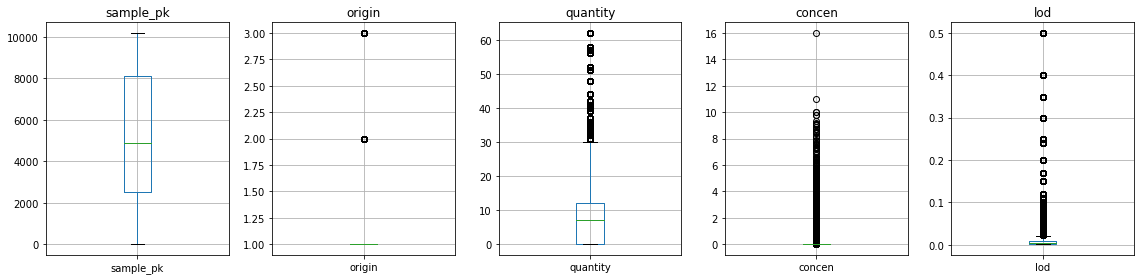

In [66]:
# Box plot for numeric columns for having a look at the outliers
fig = plt.figure(figsize=(16,4))

for col, i, in zip(num_cols, range(num_cols_len)):
    axes = fig.add_subplot(1,5,i+1)
#    cols = 2[col].notna()
    sr2_wonan.boxplot(col)
    axes.set_title(col)
    
fig.tight_layout()
plt.show()

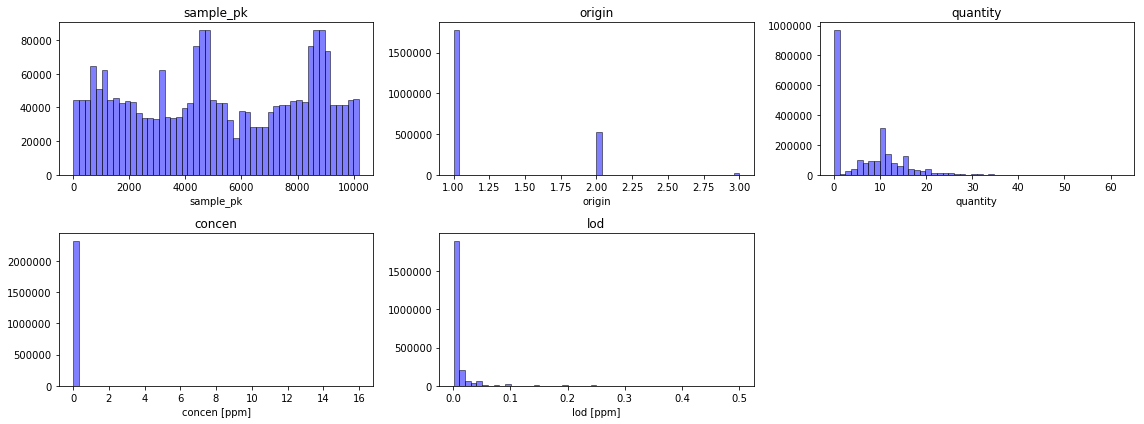

In [67]:
# Histogram plot for numeric columns for checking distribution profile

fig = plt.figure(figsize=(16,6))

for col, i, in zip(num_cols, range(num_cols_len)):
    axes = fig.add_subplot(2,3,i+1)
    axes.hist(sr2_wonan[col],bins=50, color='b',alpha=0.5, edgecolor='black')
    axes.set_title(col)
    if (col == 'concen') | (col == 'lod'):
        axes.set_xlabel(col + str(' [ppm]'))
    else:
        axes.set_xlabel(col)
    
fig.tight_layout()
plt.show()

> **Remark**:
<br> - The data in `concen`, `lod` and `quantity` display Gaussian-skew distribution, which may requires feature engineering. 
<br> - As next steps, let' have a look at the distributions per frutis/vegetables for these columns.

200it [00:06, 31.02it/s]                         


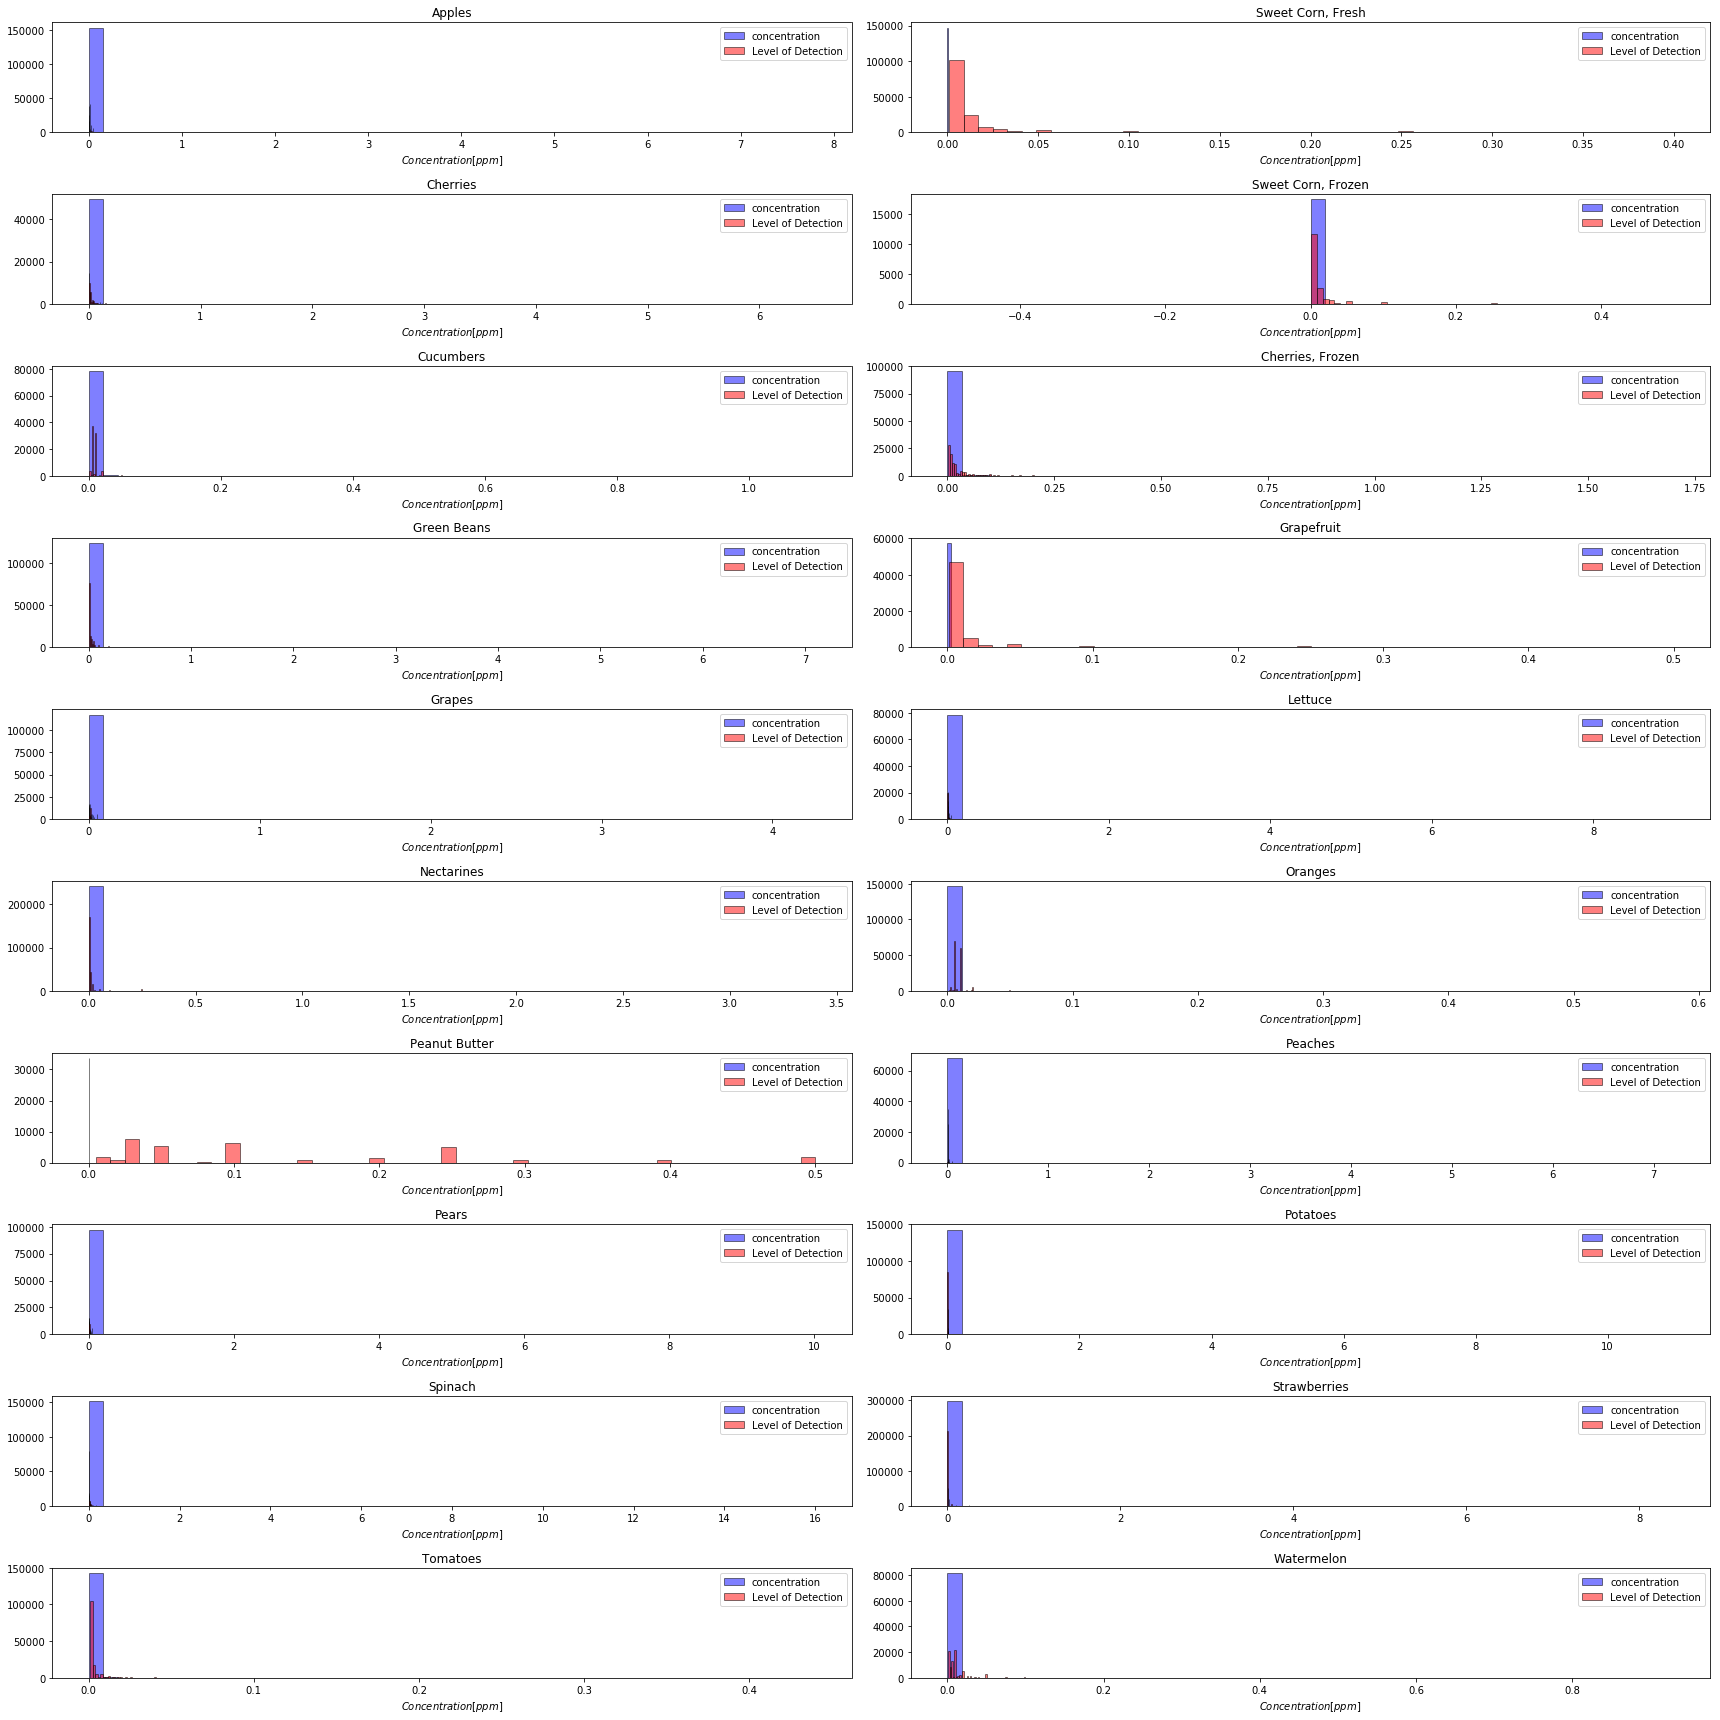

In [68]:
# histogram of concen column per fruits/vegetables for checking distribution profile

fig = plt.figure(figsize=(24,24))

col_comname = sr2_wonan['commod Name'].unique()
col_comname_len = len(col_comname)

with tqdm(total=100) as pbar:
    for c, i, in zip(col_comname, range(col_comname_len)):
            axes = fig.add_subplot(10,2,i+1)
            vals = sr2_wonan.loc[sr2_wonan['commod Name'] == c,]['concen']
            axes.hist(vals, bins=50, color='b', alpha=0.5, edgecolor='black',label='concentration') 
            #axes.hist(np.log1p(cols_nans), bins=50, color='r', alpha=0.5, edgecolor='black',label='without NaNs applying log1p ') 
            vals2 = sr2_wonan.loc[sr2_wonan['commod Name'] == c,]['lod']
            axes.hist(vals2, bins=50, color='r',alpha=0.5,edgecolor='black',label='Level of Detection')
            
            axes.set_title(c)
            axes.legend()
            axes.set_xlabel('$Concentration [ppm]$')
            #axes.set_xlim(0,0.3)
            #sleep(0.01)
            pbar.update(10)
            
fig.tight_layout()
plt.show()

> **Remarks**: 
<br> - We can see that we have many outliers and for some vegetables/fruits the values from the column `concen` exceeds the limit of detection such as for `spinach` and `apple` for example.
<br> - They are no negative values for `peanut Butter` and `Sweet Corn, Frozen`

In [69]:
# Check that the column 'Peanut Butter' does not have any negative values
#val_PeanutButter = sr2_wonan.loc[sr2_wonan['commod Name'] == 'Peanut Butter',][['lod','concen']]
#val_PeanutButter

### 2.8 Outliers Analysis

200it [02:23,  1.40it/s]                         


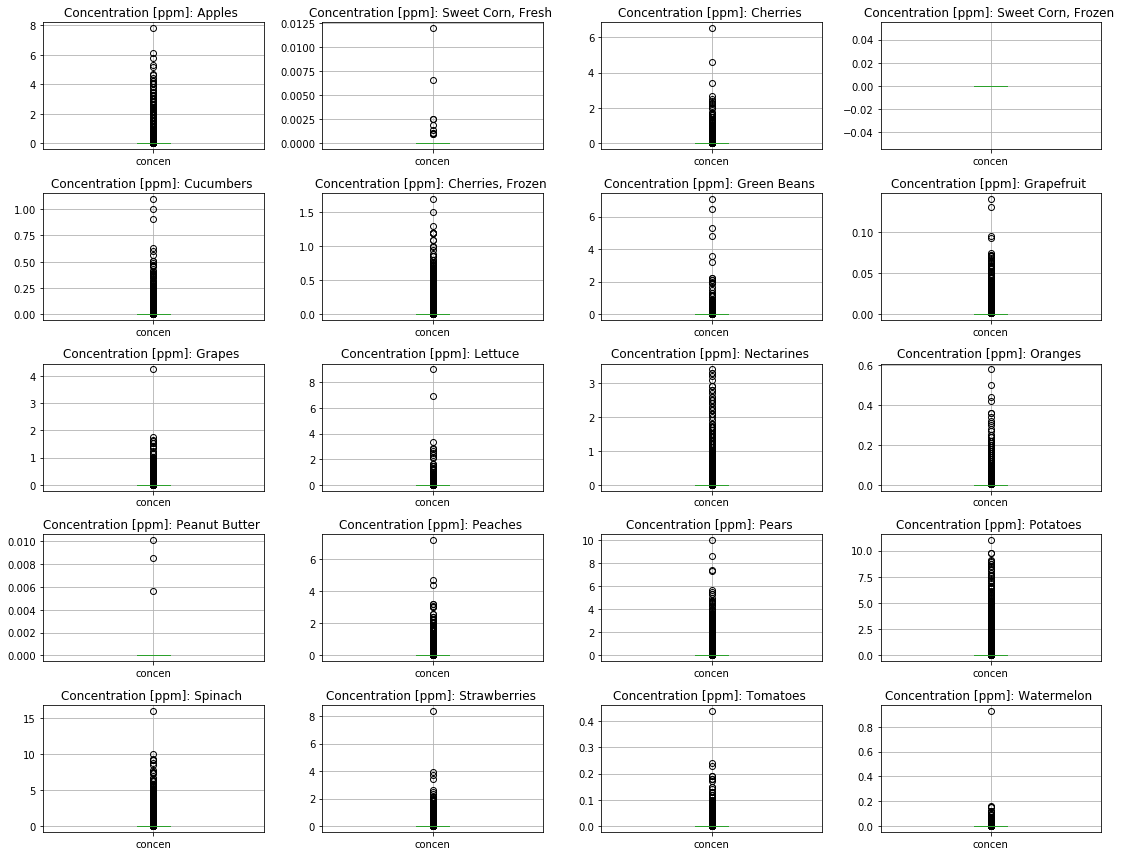

In [70]:
# Boxplot of concen column per fruits/vegetables for checking outliers
fig = plt.figure(figsize=(16,12))

with tqdm(total=100) as pbar:
    for c, i in zip(col_comname, range(col_comname_len)):
            axes = fig.add_subplot(5,4,i+1)
            vals = sr2_wonan.loc[sr2_wonan['commod Name'] == c,].notna()
            sr2_wonan[vals].boxplot('concen')
            axes.set_title('Concentration [ppm]: {} '.format(c))
            #sleep(0.01)
            pbar.update(10)
    
fig.tight_layout()
plt.show()

> **Remark**:
<br> - Some data display bigger data scattering than others, like `nectarines`, `Spinach`, `Apples`compared to `Oranges` et `Grappe-fruits`

In [71]:
# Outlier detection
index_outliers = []
Threshold= 3 # times the IQR

for col in num_cols:
    sr2_wozeros = sr2_wonan[sr2_wonan[col]!=0] # Remove the 0 values, which can impact the ourliers score
    q03 = percentile(sr2_wozeros[col], 3) #Optimized value: 97, 3% could be adjusted depending on the analysis
    q97 = percentile(sr2_wozeros[col], 97)
    iqr = q97 - q03
    lower = q03 - iqr * Threshold
    upper = q97 + iqr * Threshold
    result = (sr2_wozeros[(sr2_wozeros[col] < lower) | (sr2_wozeros[col] > upper)].index)
    index_outliers.extend(result)      
    
print('-'*50)
print('lenght of the outliers rows:',len(index_outliers))
print('lenght of dataset rows:',len(sr2_wonan))
print('% of outlier rows over the whole data: {:.2f} %'.format(100*len(index_outliers)/len(sr2_wonan)))
print('-'*50)


--------------------------------------------------
lenght of the outliers rows: 7616
lenght of dataset rows: 2333911
% of outlier rows over the whole data: 0.33 %
--------------------------------------------------


In [72]:
# Data without outliers
index_wooutliers = sr2_wonan.index.difference(index_outliers)

In [73]:
# DataFrame gathering the outliers and not the outliers
results_wonan_outliers = sr2_wonan.loc[index_outliers,:]
results_wonan_wooutliers = sr2_wonan.loc[index_wooutliers,:]

print('-'*50)
print('lenght of the not outliers rows:',len(index_wooutliers))
print('% of outlier rows over the whole data: {:.2f} %'.format(100*len(index_wooutliers)/len(sr2_wonan)))
print('-'*50)

--------------------------------------------------
lenght of the not outliers rows: 2326295
% of outlier rows over the whole data: 99.67 %
--------------------------------------------------


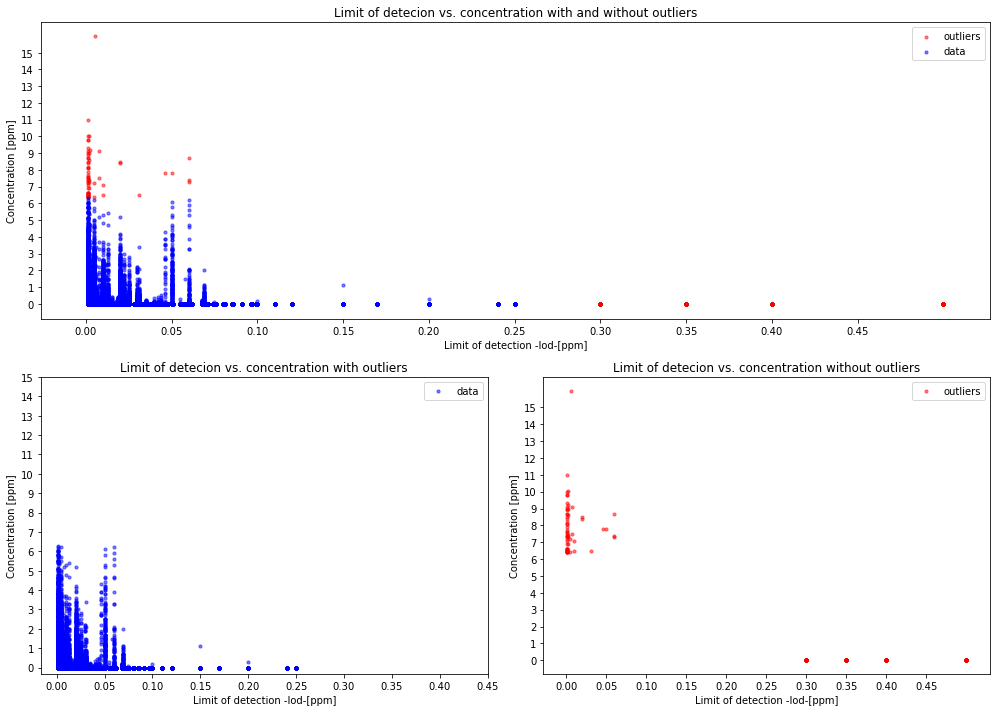

In [74]:
# outliers data vs. whole dataset 
#fig, ax = plt.subplots(3, 1, figsize=(14,10))
gs = fig.add_gridspec(2,2)

fig = plt.figure(figsize=(14,10))

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])


xaxis_title = 'Limit of detection -lod-[ppm]'
yaxis_title = 'Concentration [ppm]'

max_x = results_wonan_outliers['lod'].max()
max_y = results_wonan_outliers['concen'].max()

xaxis_value = np.arange(0,max_x,0.05)
yaxis_value = np.arange(0,max_y,1.)

plt.setp(ax, xticks=xaxis_value, xlabel=xaxis_title, yticks=yaxis_value, ylabel=yaxis_title)

ax1.scatter(results_wonan_outliers['lod'], results_wonan_outliers['concen'],c='r',alpha=0.5, s=10, label='outliers',)
ax1.scatter(results_wonan_wooutliers['lod'], results_wonan_wooutliers['concen'],c='b',alpha=0.5, s=10, label='data')

ax1.set_title('Limit of detecion vs. concentration with and without outliers')
ax1.set_xlabel(xaxis_title)
ax1.set_ylabel(yaxis_title)
ax1.set_xticks(xaxis_value)
ax1.set_yticks(yaxis_value)
ax1.legend()

ax2.scatter(results_wonan_wooutliers['lod'], results_wonan_wooutliers['concen'],c='b',alpha=0.5, s=10, label='data',)
ax2.set_title('Limit of detecion vs. concentration with outliers')
ax2.set_xlabel(xaxis_title)
ax2.set_ylabel(yaxis_title)
ax2.set_xticks(xaxis_value)
ax2.set_yticks(yaxis_value)
ax2.legend()

ax3.scatter(results_wonan_outliers['lod'], results_wonan_outliers['concen'],c='r',alpha=0.5, s=10, label='outliers')
ax3.set_title('Limit of detecion vs. concentration without outliers')
ax3.set_xlabel(xaxis_title)
ax3.set_ylabel(yaxis_title)
ax3.set_xticks(xaxis_value)
ax3.set_yticks(yaxis_value)
ax3.legend()

fig.tight_layout()
plt.show()

> **Remarks**:
<br> - The outliers are part of the analysis since concentration is measured and might exceed some tolerance values, given indication about the level of contaminations.
<br> - Most of the outliers needs to be kept for analysis purposes but some needs to be removed base on threshold for ensuring good results accuracy when machine learning algorithmn will be applied. 
<br> - The threshold is 25/75%, which is too big impacting 35% of the non null data, a 10/90% approach impacts 2.3%, whereas 3/97% gives 0.5-1%.
<br> - The latter can be see as a reasonable approach, eliminating the extrem outliers while keeping enought data for analysis purposes. This has been chosen as final EDA.

200it [02:22,  1.40it/s]                         


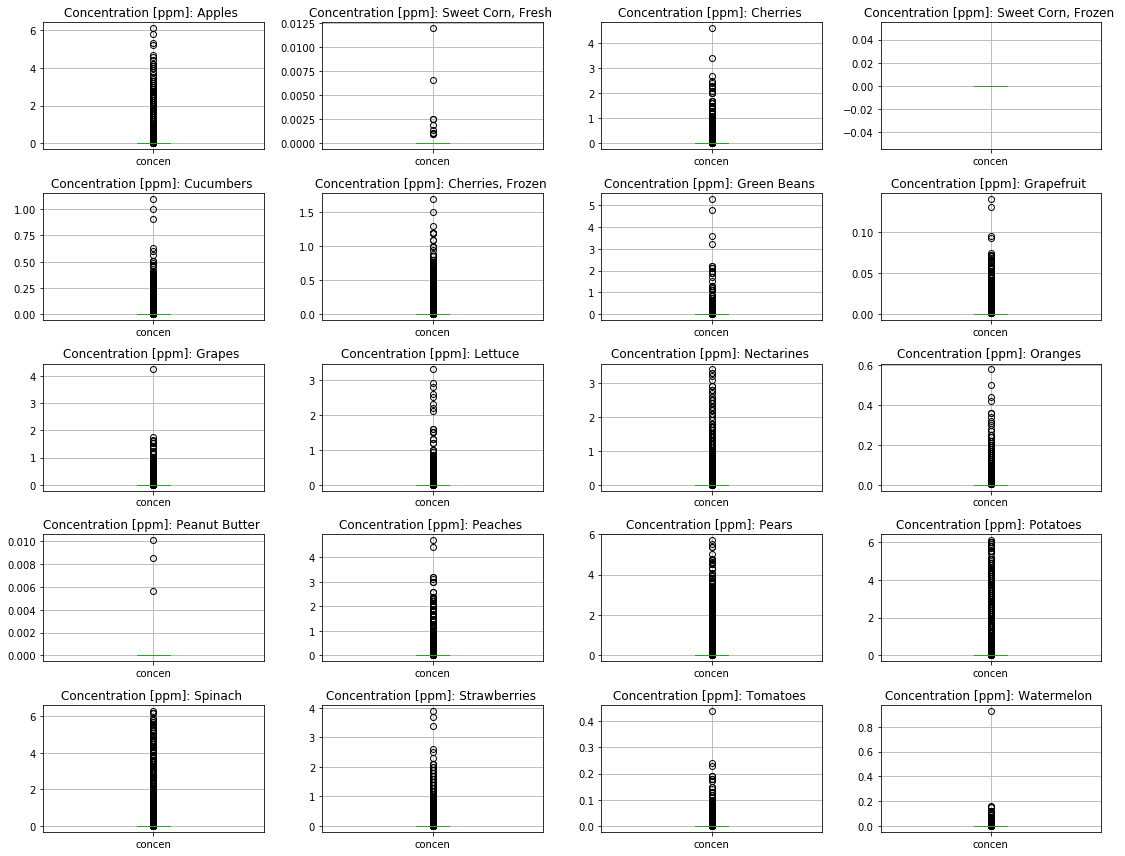

In [75]:
# Boxplot of concen column per goods after cleaning outliers (5/95%)
fig = plt.figure(figsize=(16,12))

col_num_wooutliers = results_wonan_wooutliers['commod Name'].unique()
col_num_wooutliers_len = len(col_num_wooutliers)

with tqdm(total=100) as pbar: 
    for c, i, in zip(col_num_wooutliers, range(col_num_wooutliers_len)):
            axes = fig.add_subplot(5,4,i+1)
            vals_woutliers = results_wonan_wooutliers.loc[results_wonan_wooutliers['commod Name'] == c,].notna()
            results_wonan_wooutliers[vals_woutliers].boxplot('concen')
            axes.set_title('Concentration [ppm]: {} '.format(c))
#            sleep(0.1)
            pbar.update(10)
    
fig.tight_layout()
plt.show()

### 2.9 Aggregated Data Countries/Pesticides/Fruits for Bar Plots Analysis

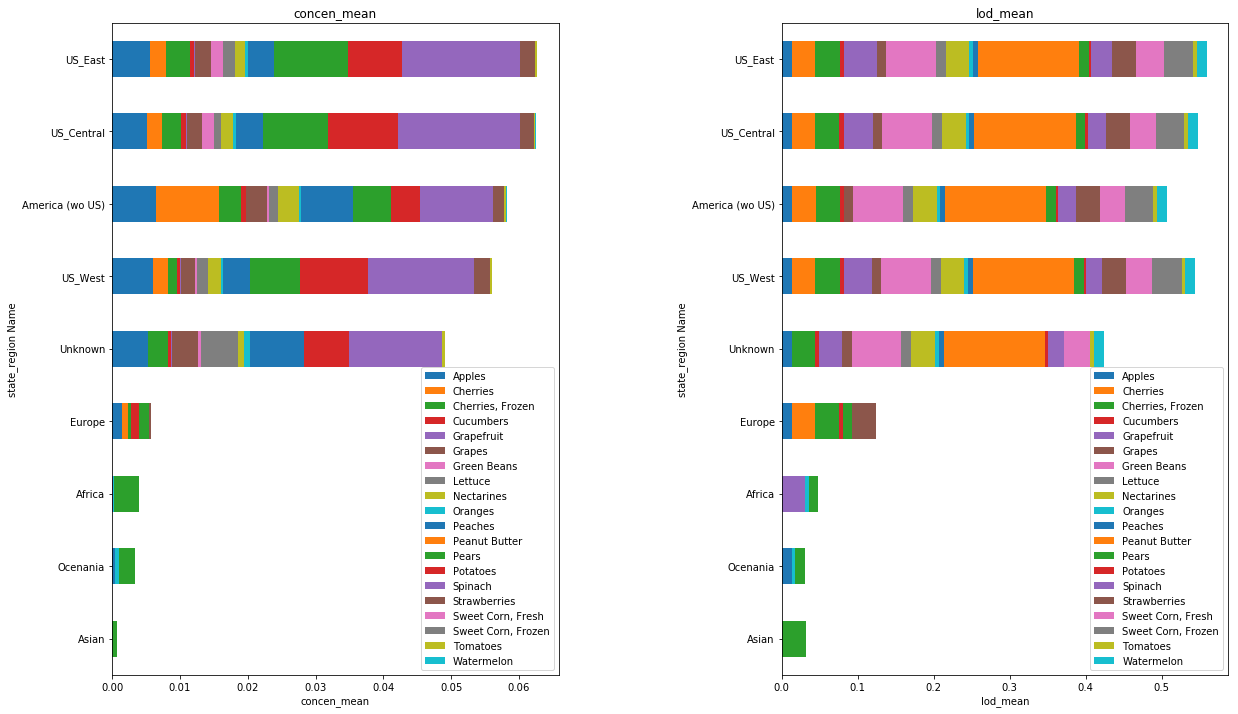

/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/plotting/_tools.py:203: UserWarning: When passing multiple axes, layout keyword is ignored
  "ignored", UserWarning)
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/plotting/_core.py:1801: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


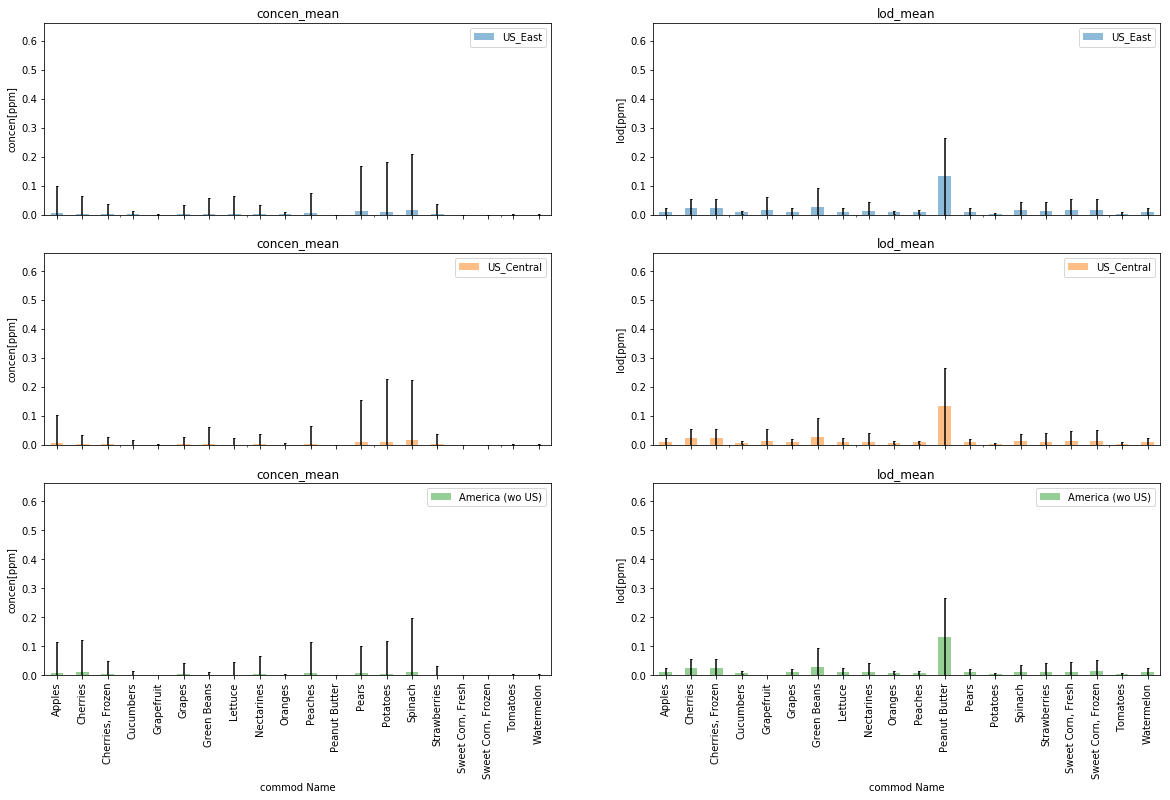

In [76]:
#  Aggregated plots fruits vs. countries/US State for 'concen' and 'lod' displaying mean and std values 
groupby_plot(sr2_wonan, 'commod Name','state_region Name', 'concen', 'lod')

> **Remarks**:
<br> - Analysis showing the most fruits/vegetables vs. region. Depending on the sample data, the results are slightly different but shows big standard deviation in `concen` dataset due to high outliers. 
<br> - In addition, we can observe that`spinard`is a vegetable facing huge concentration of pesticides.
<br> - US state and America have more higher level of pesticides compared to Europe for example where the regulations are more stringent.

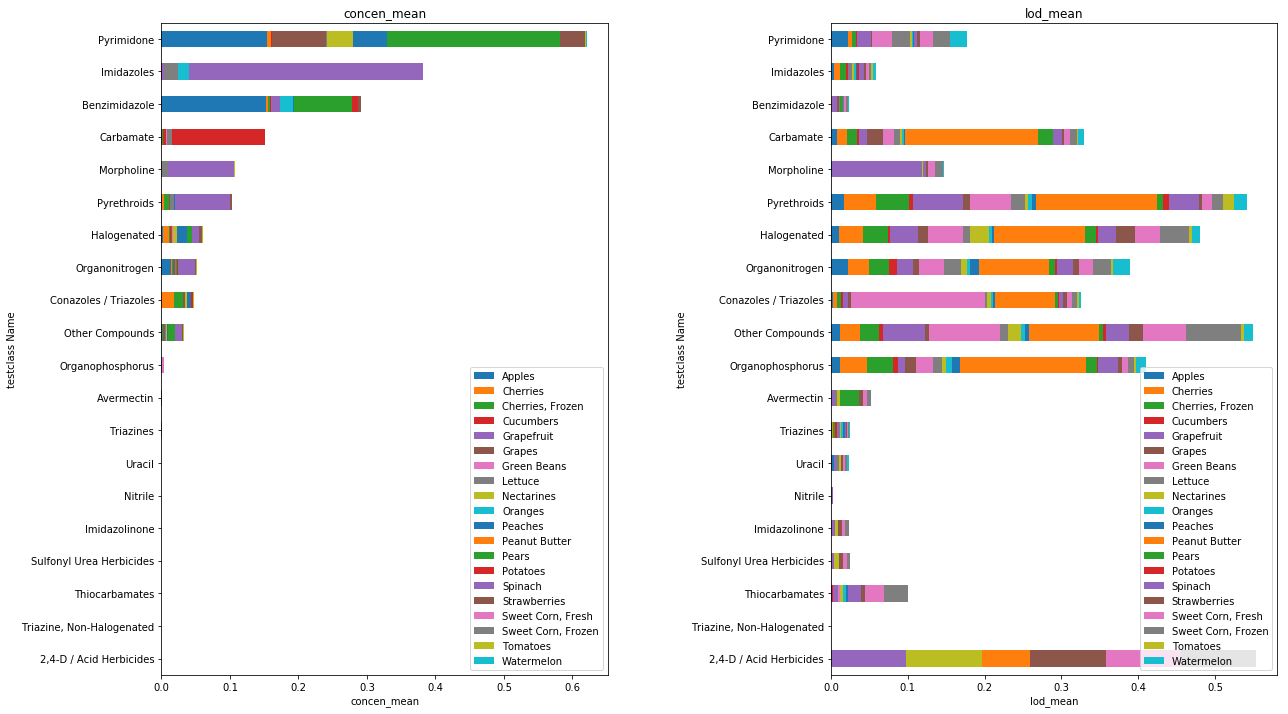

/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/plotting/_tools.py:203: UserWarning: When passing multiple axes, layout keyword is ignored
  "ignored", UserWarning)
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/plotting/_core.py:1801: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


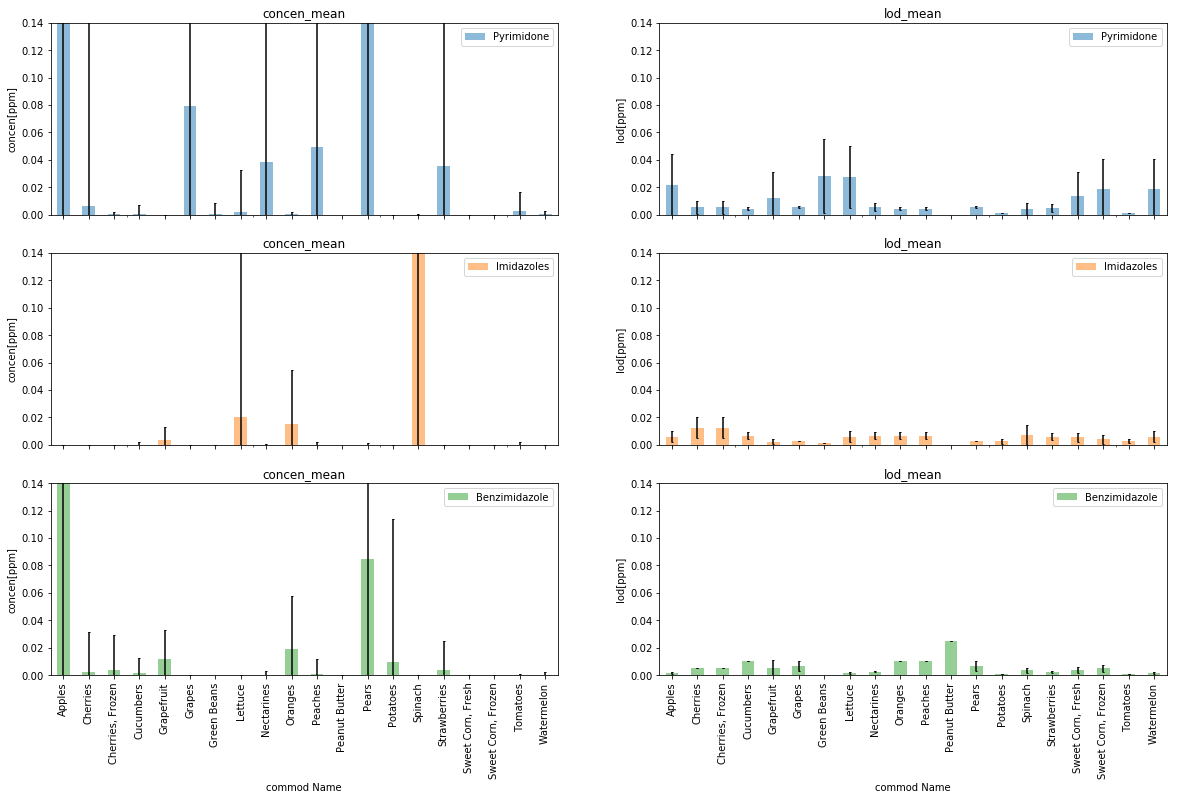

In [77]:
#  Aggregated plots fruits vs. pesticides for 'concen' and 'lod' displaying mean and std values 
groupby_plot(sr2_wonan,'commod Name','testclass Name','concen','lod')

> **Remarks**:
<br> - Analysis showing the most frequent pesticides vs. fruits/vegetables. The results display big standard deviation in `concen` data base due to high outliers.
<br> - We can notice that the fruits/vegetables suchs as `Apples`, `Spinach`and `Cherries Frozen` are very impacted with very high level of pesticides corresponding to the pesticide class `pyrimidone`for `Apples` and `Cherries Frozen`, `imidazoles` for `Spinach` 
<br> - Some of these values are very well above the limit of detection.

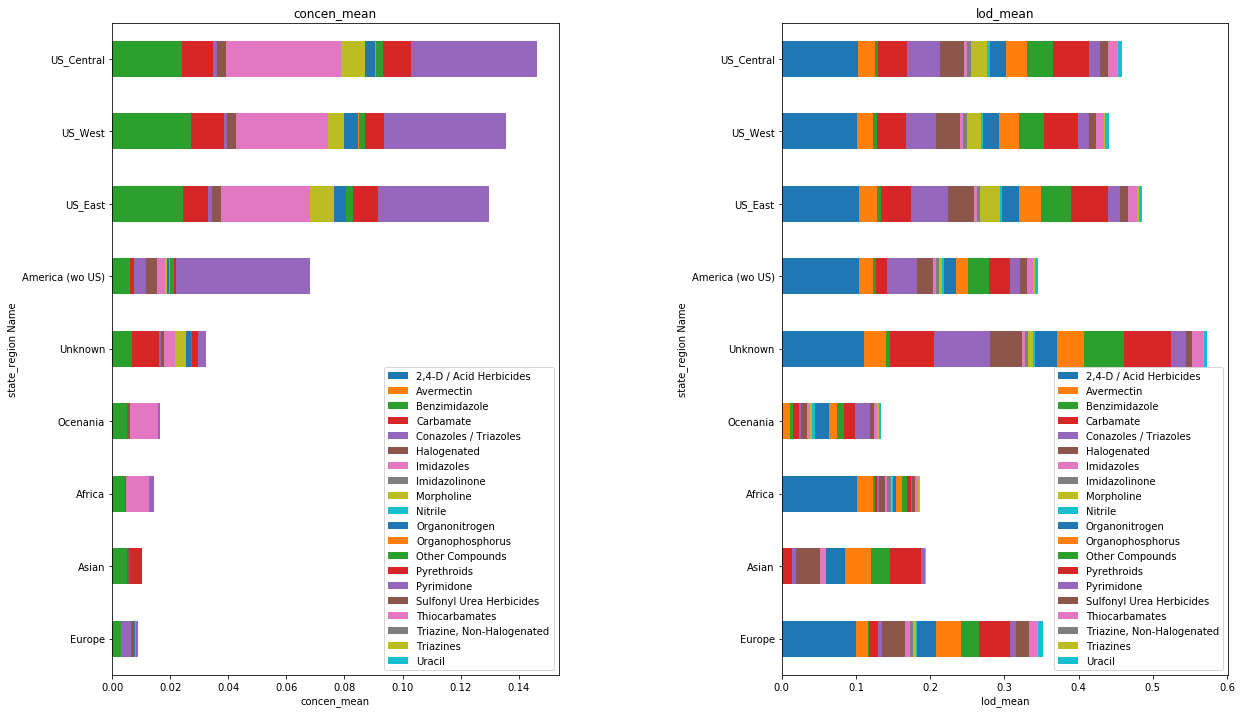

/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/plotting/_tools.py:203: UserWarning: When passing multiple axes, layout keyword is ignored
  "ignored", UserWarning)
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/plotting/_core.py:1801: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


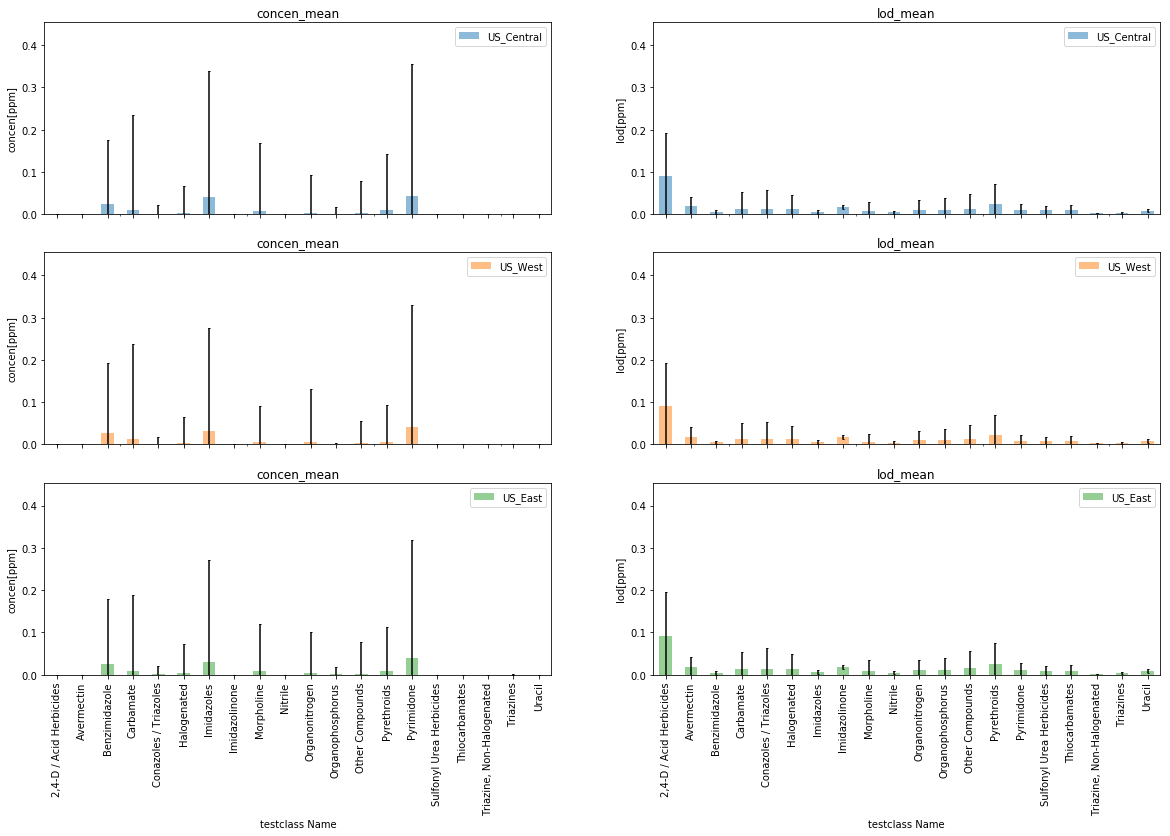

In [78]:
#Aggregated plots pesticides vs. countries/US-state plotting for 'concen' and 'lod' displaying mean and std values 
groupby_plot(sr2_wonan,'testclass Name','state_region Name','concen','lod')

> **Remarks**:
<br> - Analysis showing the most frequent pesticides vs. country/US state.
<br> - US state and America (south/central) face higher level of pesticides concentration for their fruits/vegatebles than the rest of the world, by a factor 10 between US and Europe and Asian.
<br> - Some level of concentrations are even higher than the limit of detection, it is the case for the pesticide classes `Pyrimidone`,`Imidazoles`.

### 2.10 Time information 

In [79]:
# Let's aggregate together the columns time
cols = ['day','month','year']
sr2_wonan['times'] = sr2_wonan[cols].apply(lambda row: '.'.join(row.values.astype(str)),axis=1)
sr2_wonan['times'].head()

0    20.01.15
1    20.01.15
2    20.01.15
3    20.01.15
4    20.01.15
Name: times, dtype: object

In [80]:
sr2_wonan['times'] = pd.to_datetime(sr2_wonan['times'], format='%d.%m.%Y', errors='ignore')
sr2_wonan['times'].dtypes
sr2_wonan['times'].head()

0    20.01.15
1    20.01.15
2    20.01.15
3    20.01.15
4    20.01.15
Name: times, dtype: object

In [81]:
print(sr2_wonan['times'].value_counts().head())

08.09.15    47483
20.04.15    47473
20.01.15    44237
16.11.15    43779
26.01.15    42545
Name: times, dtype: int64


In [82]:
print(sr2_wonan['month'].value_counts())

05    222032
06    209806
08    208954
07    208319
09    198787
03    195724
02    194021
04    189202
01    188989
11    174871
10    173647
12    169559
Name: month, dtype: int64


In [83]:
print(sr2_wonan['month'].value_counts())

05    222032
06    209806
08    208954
07    208319
09    198787
03    195724
02    194021
04    189202
01    188989
11    174871
10    173647
12    169559
Name: month, dtype: int64


> **Remark**:
<br> - The column `month` can be kept for the machine learning since it brings added information for analysing `fruits/vegetables/pesticide` vs. `month`; the columns `year`, `day` and `times` can be deleted as not bringing any added values.

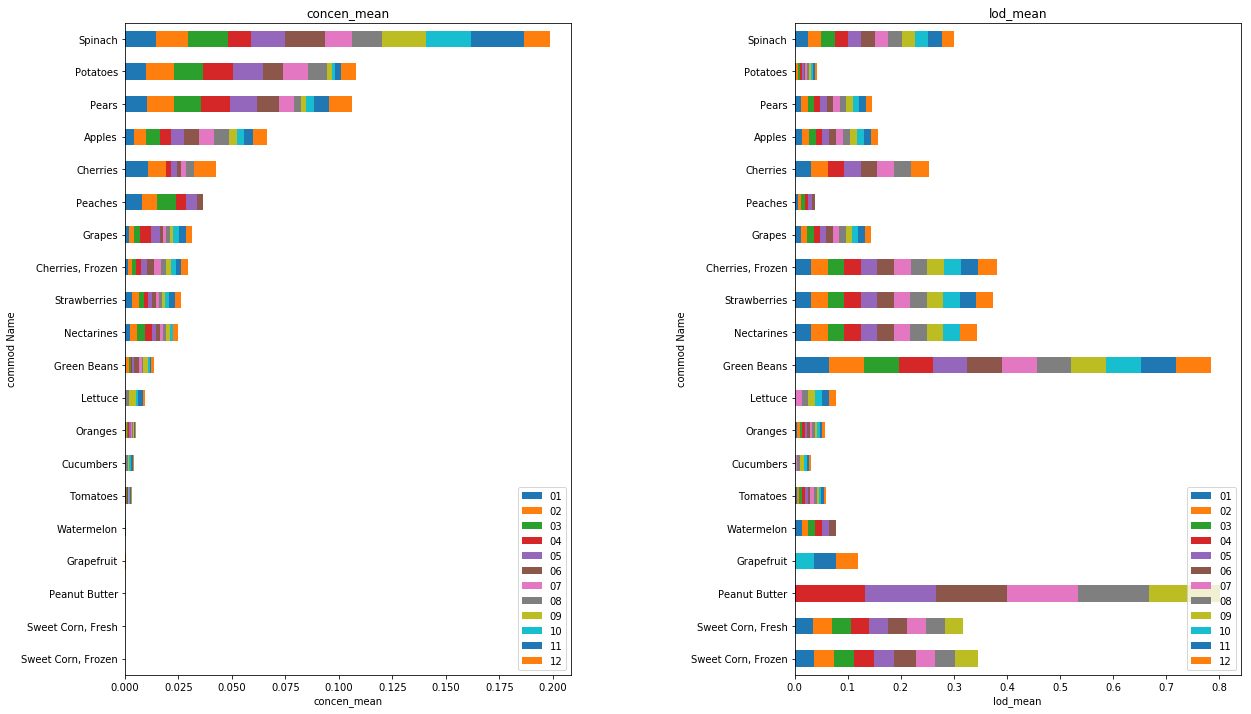

/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/plotting/_tools.py:203: UserWarning: When passing multiple axes, layout keyword is ignored
  "ignored", UserWarning)
/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/plotting/_core.py:1801: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


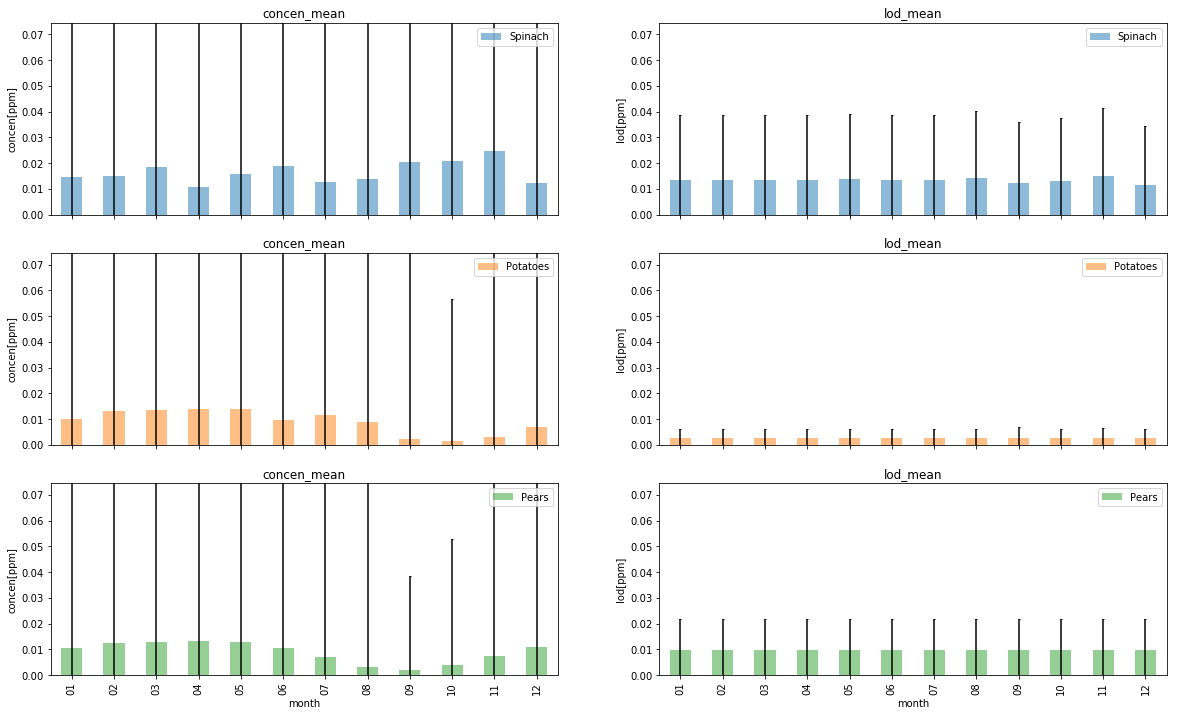

In [84]:
#  Aggregated plots month vs. fruits/vegetables for 'concen' and 'lod' displaying mean and std values 
groupby_plot(sr2_wonan, 'month','commod Name', 'concen', 'lod')

> **Remark**:
<br> - Again standard deviation is very important
<br> - Most of the fruits/vegetables are spread over the year in a constant level in terms of pers.
<br> - The 3 most important vegetables/fruits exposed to the highest level of pesticide over 2015 are`Spinach`, `Potatoes`, `Pears`, with level approaching and exceeding the level of detection.

### 2.11 Feature Engineerings for numerical/non numerical For Preparing Data Machine Learning

In [85]:
# Make a copy for decoupling the first exploratory from the EDA
sr3_wonan = sr2_wonan.copy()

In [86]:
#sortout_topvalues(sr3_wonan, 10)

> **Remarks**: 
<br> The present chapter is split as follows:
<br> - 2.11.1 Further analysis is needed for deciding what to do with the remaning NANs value in columns `Name`and `EPA Tolerance`.
<br> - 2.11.2 Drop columns that don't bring any added value`
<br> - 2.11.3  Numerical columns need to be analysed - distribution-  apply engineering features if needed. 
<br> - 2.11.4 Non-numerical columns needs to be investigated column by column and clean them accordingly
<br> - 2.11.5 Check if some numerical columns have some collinearities and if correlations exist or not with the target column.
<br> - 2.11.6 Apply transformation - outliers, resiudal cleanings, residual dropped columns, 1D or 2D encoding

#### 2.11.1 Remaining NANs values

In [87]:
# The remaining NANs values express in % per column of the dataset
Rem_NANs_vals = (100*sr3_wonan.isna().sum()/len(sr3_wonan)).to_frame().round(2).sort_values(by=0, ascending=False).head(5)
Rem_NANs_vals.rename(columns={0:'NANs in %'})

,NANs in %
region Name,77.30
country Name,77.30
EPA Tolerance,0.25
sample_pk,0.00
pestcode Name,0.00


In [88]:
# The remaining 0s values express in % per column of the dataset
Rem_0s_vals = (100*sr3_wonan.isin([0]).sum()/len(sr3_wonan)).to_frame().round(2).sort_values(by=0, ascending=False).head(5)
Rem_0s_vals.rename(columns={0:'0s in %'})

,0s in %
concen,98.34
quantity,41.68
lod,0.00
confmethod,0.00
confmethod2,0.00


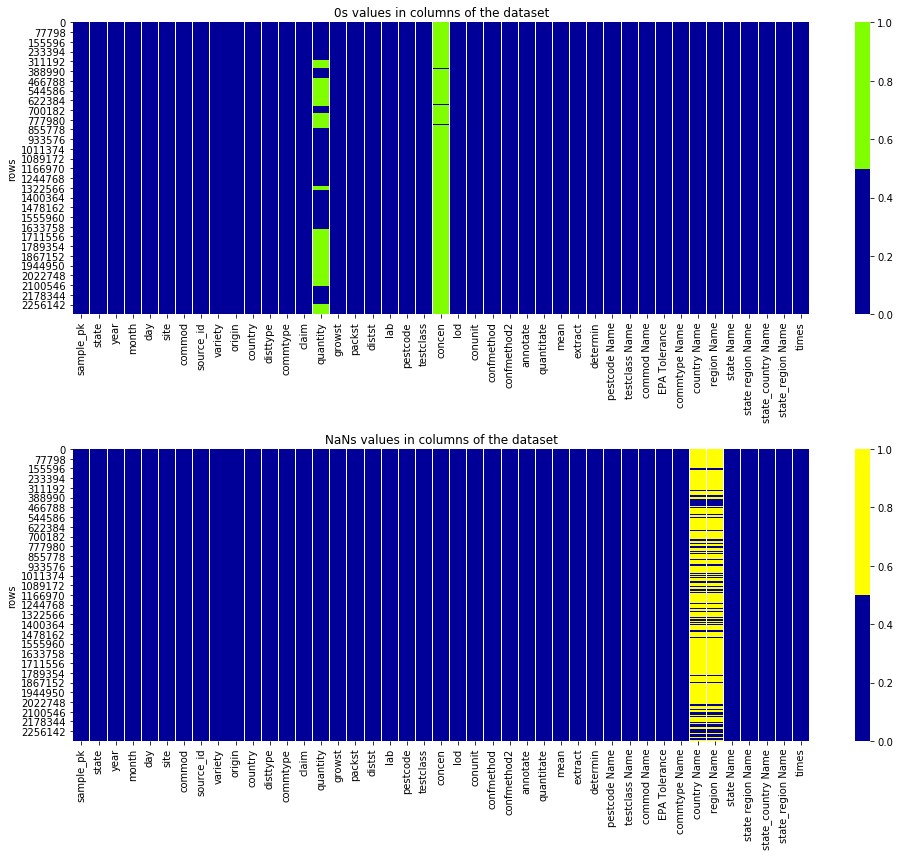

In [89]:
'''
Dislay the 0s and NANs values per column in plot format
Ref: https://towardsdatascience.com/data-cl
''' 

fig, ax = plt.subplots(2,1,figsize=(14,12))


col_0s = ['#000099', '#7FFF00'] # specify the colours - green is 0. blue different from 0.
col_NaNs = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.

t = len(sr3_wonan.columns)

# Plot the 0s values
sns.heatmap(sr3_wonan[sr3_wonan.columns[0:t]].isin([0]),cmap=col_0s, ax=ax[0]) 
ax[0].set_title('0s values in columns of the dataset')
ax[0].set_ylabel('rows')

# Plot the NAN values
sns.heatmap(sr3_wonan[sr3_wonan.columns[0:t]].isnull(),cmap=col_NaNs, ax=ax[1]) 
ax[1].set_title('NaNs values in columns of the dataset')
ax[1].set_ylabel('rows')


plt.tight_layout()
plt.show()

> **Remarks**:
<br> - As expected the columns `concen`and `quantity` show huge number of 0s values as we replaced their NANs values by 0s.
<br> - All the columns ends up with `Name` will be removed since they have been used for the graphic analysis (viusal purposes) but don't have any added values for models.
<br> - We need to check the columns `EPA Tolerance` and `variety` depending on the data sampling since they display some NANs values.

In [90]:
# Work with EPA Tolerance
print(sr3_wonan['EPA Tolerance'].value_counts(normalize=True))

NT      0.479059
0.05    0.094829
0.1     0.065722
0.2     0.037450
1.0     0.036958
2.0     0.033922
0.02    0.032421
0.01    0.024517
0.5     0.024501
0.3     0.017041
0.20    0.012730
0.10    0.012060
0.04    0.011149
0.08    0.010136
0.15    0.009789
3.0     0.009717
0.03    0.008735
8       0.008713
5.0     0.005856
1.5     0.004877
SU      0.004376
2       0.004376
0.4     0.004374
EX3     0.004240
0.25    0.004240
0.80    0.004063
5       0.003741
0.07    0.003737
0.6     0.003466
16      0.002979
0.40    0.002846
0.7     0.002684
EX      0.002551
0.35    0.002224
2.5     0.001945
0.70    0.001505
6.25    0.001151
EX2     0.001082
0.50    0.001036
3       0.001010
0.60    0.000744
4.0     0.000706
10.0    0.000607
0.09    0.000135
Name: EPA Tolerance, dtype: float64


> **Remarks**: 
<br> - It has been decided to put NT Not Tolerant as 0.
<br> - Based on the low remaining non numerical values compared to whole dataset; it has been decided to redistribute these data to the most frequent ones.

In [91]:
'''
Extract non values from column EPA Tolerance
'''
No_numerical_EPA_NT = sr3_wonan.loc[(sr3_wonan['EPA Tolerance']=='NT')|(sr3_wonan['EPA Tolerance']=='SU') | 
                           (sr3_wonan['EPA Tolerance']=='EX')|(sr3_wonan['EPA Tolerance']=='EX1')| 
                           (sr3_wonan['EPA Tolerance']=='EX2')|(sr3_wonan['EPA Tolerance']== 'EX3')|
                           (sr3_wonan['EPA Tolerance']== 'nan'),]

No_numerical_EPA = sr3_wonan.loc[(sr3_wonan['EPA Tolerance']=='SU') | (sr3_wonan['EPA Tolerance']=='EX')|
                           (sr3_wonan['EPA Tolerance']=='EX1')| (sr3_wonan['EPA Tolerance']=='EX2')|
                           (sr3_wonan['EPA Tolerance']=='EX3')|(sr3_wonan['EPA Tolerance']== 'nan'),]

print('-'*50)
print('lenght non numerical element EPA Tolerance with NT: {}'.format(len(No_numerical_EPA_NT)))
print('in % with NT {:.2f}%'.format(100*len(No_numerical_EPA_NT)/len(sr3_wonan['EPA Tolerance'])))
print('-'*50)

print('lenght non numerical element EPA Tolerance without NT: {}'.format(len(No_numerical_EPA)))
print('in % without NT {:.2f}%'.format(100*len(No_numerical_EPA)/len(sr3_wonan['EPA Tolerance'])))
print('-'*50)

--------------------------------------------------
lenght non numerical element EPA Tolerance with NT: 1143788
in % with NT 49.01%
--------------------------------------------------
lenght non numerical element EPA Tolerance without NT: 28516
in % without NT 1.22%
--------------------------------------------------


In [92]:
'''
Replace the remaining not value in column 'EPA Tolerance' by their associated most frequency values
'''
# Replace NT Not tolerant by 0
sr3_wonan.loc[sr3_wonan['EPA Tolerance']=='NT','EPA Tolerance'] = 0
# Transform no numerical value into NANs
sr3_wonan.loc[No_numerical_EPA.index,'EPA Tolerance'] = np.nan

replacedvalues_freq(sr3_wonan, 'EPA Tolerance')

# Transform the column EPA Tolerance from object to float
sr3_wonan['EPA Tolerance'] = sr3_wonan['EPA Tolerance'].convert_objects(convert_numeric=True) 
sr3_wonan['EPA Tolerance'].dtypes

/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if sys.path[0] == '':


dtype('float64')

In [93]:
# check  NANs values for the column 'variety'
sr3_wonan['variety'].value_counts(normalize=True).head()

NA         0.167536
N/A        0.068731
Unknown    0.063292
Navel      0.035896
Yellow     0.034346
Name: variety, dtype: float64

In [94]:
'''
Extract non values from column EPA Tolerance
'''

No_numerical_Variety_NT = sr3_wonan.loc[(sr3_wonan['variety']=='NA')|((sr3_wonan['variety']=='Unknown') | 
                           (sr3_wonan['variety']=='N/A')),]

print('lenght non numerical element in column variety: {}'.format(len(No_numerical_Variety_NT)))
print('in % over the whole column {:.2f}%'.format(100*len(No_numerical_Variety_NT)/len(sr3_wonan['variety'])))

lenght non numerical element in column variety: 699144
in % over the whole column 29.96%


> **Remark**: 
<br> the column `variety` has more than 20% as unknown values, difficult to apply the same techniques than for the column `EPA Tolerance`, decide to rename them as 'Unknown' values

In [95]:
# Replace the NA, N/A, Unknown values in column 'variety' by Unknown and check the results
sr3_wonan.loc[No_numerical_Variety_NT.index,'variety']='Unknown'
sr3_wonan['variety'].value_counts(normalize=True).head()

Unknown          0.299559
Navel            0.035896
Yellow           0.034346
Red Delicious    0.021201
Red              0.019433
Name: variety, dtype: float64

#### 2.11.2. First Drop of Useless Columns

> **Remarks**:
<br> - The columns end up with `Name` will be removed as only needed for visualization purposes
<br> - The columns related to times will be removed as not necessary, except the column `month`
<br> - Additional columns displaying only 1 value or given redundancies will be removed such as: `conunit`,`confmethod2`; others to be determined in the following analysis
<br> - The columns related to `country/state` can be removed since the column `origin` gives already the info about import country/state/unknown
<br> - The columns `country_country/region Name` created for the first EDA analysis can be kept and we can decide later which one we can drop

In [96]:
# Prepare list of dropped columns - time, columns end up with name, countries,...
dropped_cols = [c for c in sr3_wonan.columns if ('state' in c)|('country' in c)| ('Name' in c) | ('year' in c) |('day' in c) | 
                ('conunit' in c) | ('confmethod2' in c)]

dropped_cols = dropped_cols[:-2] # Keep 'state_country Name and state_region Name and decide later on which one to keep for the machine learning algo'
print(dropped_cols)

['state', 'year', 'day', 'country', 'conunit', 'confmethod2', 'pestcode Name', 'testclass Name', 'commod Name', 'commtype Name', 'country Name', 'region Name', 'state Name', 'state region Name']


In [97]:
'''
# Drop useless columns based on the previous analysis 
'''
for c in dropped_cols:
    if c not in sr3_wonan:
        print('the column', c, 'has been already deleted')
    else:   
        sr3_wonan.drop(columns=[c],axis=1, inplace=True)
        
sr3_wonan.head()

,sample_pk,month,site,commod,source_id,variety,origin,disttype,commtype,claim,...,confmethod,annotate,quantitate,mean,extract,determin,EPA Tolerance,state_country Name,state_region Name,times
0,1,01,0010,AP,,Fuji,1,H,FR,NC,...,,,,ND,805,35\r\n,0.05,California,US_West,20.01.15
1,1,01,0010,AP,,Fuji,1,H,FR,NC,...,,,,ND,805,52\r\n,0.00,California,US_West,20.01.15
2,1,01,0010,AP,,Fuji,1,H,FR,NC,...,,,,ND,805,35\r\n,0.05,California,US_West,20.01.15
3,1,01,0010,AP,,Fuji,1,H,FR,NC,...,,,,ND,805,52\r\n,0.00,California,US_West,20.01.15
4,1,01,0010,AP,,Fuji,1,H,FR,NC,...,,,,ND,805,35\r\n,0.05,California,US_West,20.01.15


#### 2.11.3. Numerical Columns

In [98]:
num_cols = sr3_wonan.select_dtypes(include=np.number).columns
print(num_cols.values)

['sample_pk' 'origin' 'quantity' 'concen' 'lod' 'EPA Tolerance']


In [99]:
'''
Check the skweness of the ditribution profile of the numerical columns 
by applying with/without log1p function
'''

skew_result = []
count_raw = 0
count_log = 0

for c in num_cols:

    if 'sample_pk' not in c:
        
        sr3_wozeros = sr3_wonan[sr3_wonan[c]!=0]# Remove the 0 values, which can impact the skewness of the distribution
        skew_vals= sr3_wozeros[c].skew() 
        skew_logvals = np.log1p(sr3_wozeros[c]).skew()

        if (skew_vals > 1.) | (skew_vals < -1.0):
            m = 'Not Gaussian profile'
        else:
            count_raw += 1
            m = 'Gaussian profile'
        
        if (skew_logvals > 1.) | (skew_logvals < -1.0):
            n= 'Not Gaussian profile'
        else:
            count_log += 1
            n= 'Gaussian profile'
            
        skew_result.append({'columns':c,
              'skewness raw data':skew_vals,
              'Skewness logarithm data':skew_logvals,
              'Comment: Raw Data':m,
              'Comments: Log Data':n
             })
    
print('Sum of raw data with Gaussian profile:', count_raw)
print('Sum of log_data with Gaussian profile:', count_log)

skew_result = pd.DataFrame(skew_result)
skew_result = skew_result[['columns','skewness raw data','Skewness logarithm data','Comment: Raw Data','Comments: Log Data']]
skew_result

Sum of raw data with Gaussian profile: 0
Sum of log_data with Gaussian profile: 1


,columns,skewness raw data,Skewness logarithm data,Comment: Raw Data,Comments: Log Data
0,origin,1.479210,1.355144,Not Gaussian profile,Not Gaussian profile
1,quantity,1.754802,-0.211534,Not Gaussian profile,Gaussian profile
2,concen,6.676450,3.404287,Not Gaussian profile,Not Gaussian profile
3,lod,7.747638,7.010028,Not Gaussian profile,Not Gaussian profile
4,EPA Tolerance,4.932496,2.108279,Not Gaussian profile,Not Gaussian profile


> **Remarks**:
<br> - As features engineering, apply the log1p to the column `quantity` can help, which is not the case for the others numerical columns.
<br> The column `sample_pk` can be removed as not bringing any added information 


#### 2.11.4. Non Numerical Columns

In [100]:
nonnum_cols_EDA = sr3_wonan.select_dtypes(exclude=np.number).columns
print(nonnum_cols_EDA.values)
col_len_EDA = len(nonnum_cols_EDA)

['month' 'site' 'commod' 'source_id' 'variety' 'disttype' 'commtype'
 'claim' 'growst' 'packst' 'distst' 'lab' 'pestcode' 'testclass'
 'confmethod' 'annotate' 'quantitate' 'mean' 'extract' 'determin'
 'state_country Name' 'state_region Name' 'times']


220it [00:12, 17.11it/s]                         


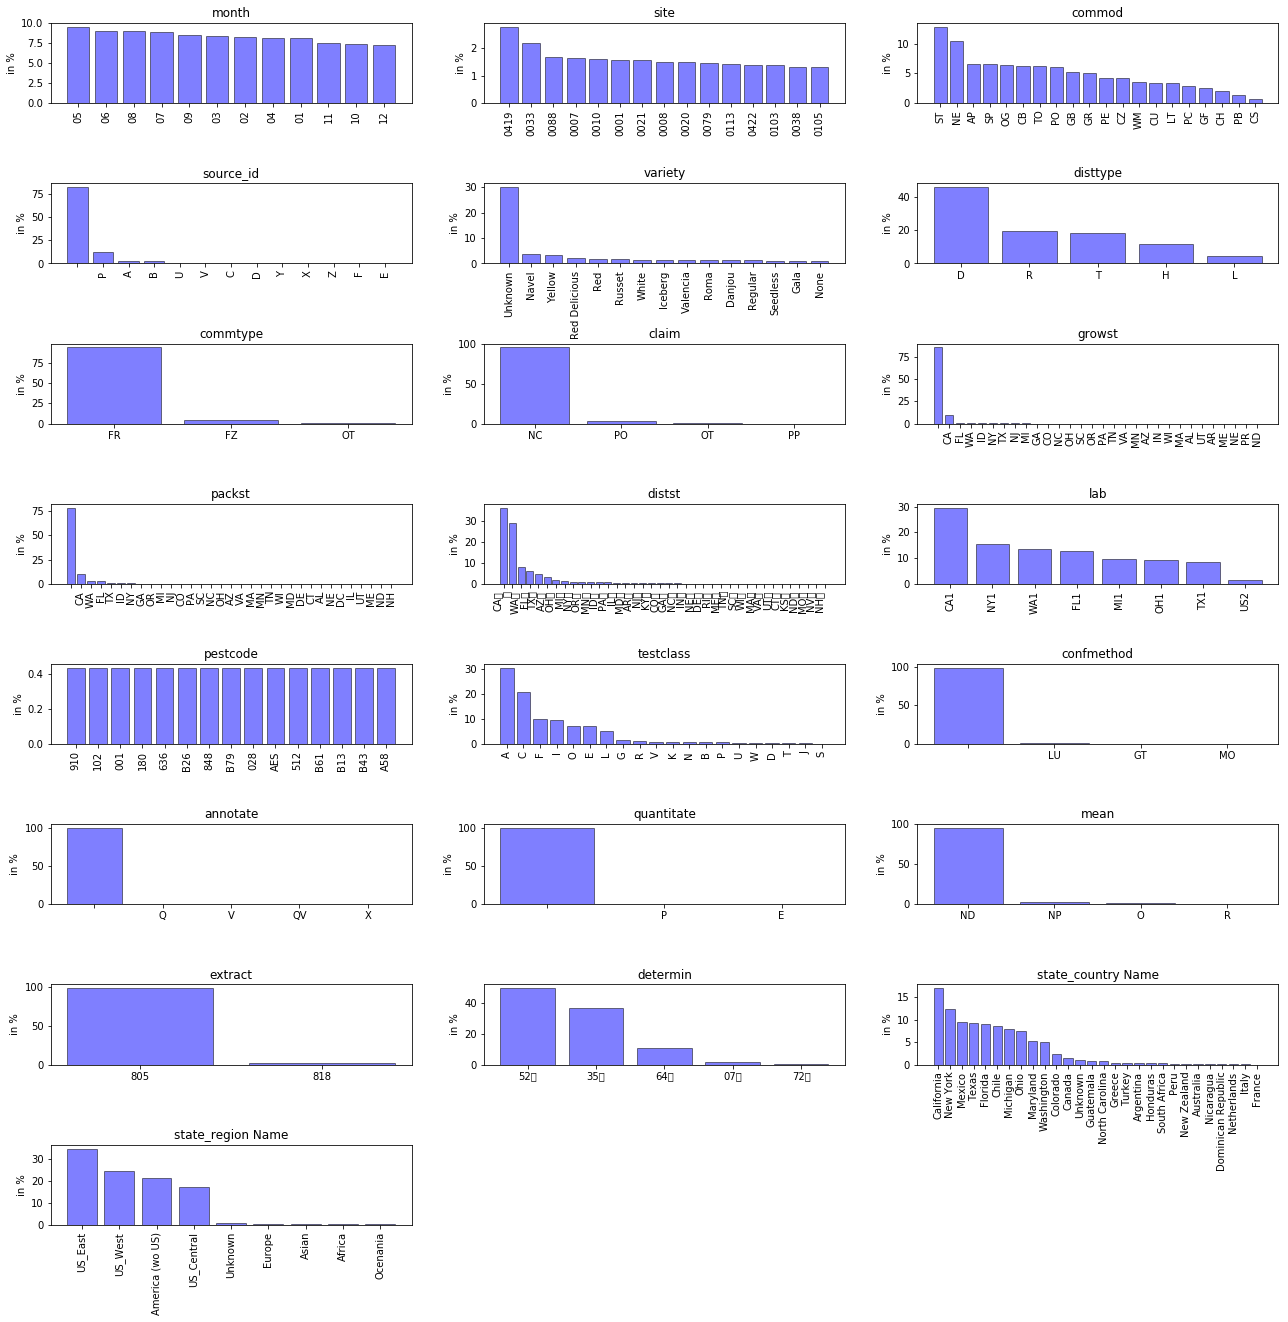

In [101]:
'''
Plot in histogram form the non numerical columns
'''
fig = plt.figure(figsize=(22,28))

with tqdm(total=100) as pbar: 

    for col, i, in zip(nonnum_cols_EDA[:-1], range(col_len_EDA)): #exclude the time from the analysis
            axes = fig.add_subplot(10,3,i+1)
            if sr3_wonan[col].nunique() > 50.: # Plot the 15 most highes values for 'site', 'variety', 'testclass', which are very long
                value_uniques_head = 100*sr3_wonan[col].value_counts(normalize=True).head(15)
                axes.bar(value_uniques_head.index, value_uniques_head,color='b',alpha=0.5,edgecolor='black')
                
            else:
                axes.bar(sr3_wonan[col].value_counts().index, 100*sr3_wonan[col].value_counts(normalize=True),color='b',alpha=0.5,edgecolor='black')
        
            if sr3_wonan[col].nunique() > 5.: 
                axes.tick_params(axis='x', rotation=90)
            
            axes.set_title(col)
            axes.set_ylabel('in %')
            #sleep(0.01) 
            pbar.update(10)
    
#fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=1.) 
plt.show()

In [102]:
# Have a look at the values_counts of the non numerical columns
for c in nonnum_cols_EDA.values:
    if sr3_wonan[c].nunique()>5:
        print('column: {}  has unique values: {}'.format(c,sr3_wonan[c].nunique()))
        print('-'*50)
    else:
        print('column: {}  has unique values: {}'.format(c,sr3_wonan[c].nunique()))
        print(sr3_wonan[c].value_counts(normalize=True))
        print('-'*50)

column: month  has unique values: 12
--------------------------------------------------
column: site  has unique values: 312
--------------------------------------------------
column: commod  has unique values: 20
--------------------------------------------------
column: source_id  has unique values: 13
--------------------------------------------------
column: variety  has unique values: 1260
--------------------------------------------------
column: disttype  has unique values: 5
D    0.460353
R    0.194901
T    0.183091
H    0.116813
L    0.044842
Name: disttype, dtype: float64
--------------------------------------------------
column: commtype  has unique values: 3
FR    0.936546
FZ    0.049013
OT    0.014441
Name: commtype, dtype: float64
--------------------------------------------------
column: claim  has unique values: 4
NC    0.954954
PO    0.034426
OT    0.010272
PP    0.000348
Name: claim, dtype: float64
--------------------------------------------------
column: growst  has

#### Listing non numerical columns:
- **1/ site**:
<br> Different codes for location 
<br> Site code for location where sample was collected (0001-9999)
<br> ['0010' '0038' '0043'...]
> **Remark**:
<br> - This columns can be deleted since information about country US/state is already collected

- **2/.commod**:  
<br> Name of fruits/vegetable 
<br> ['AP', 'CB', 'CH', 'CU', 'CZ', 'GB', 'GF', 'GR', 'LT', 'NE', 'OG',
<br> 'PB', 'PC', 'PE', 'PO', 'SP', 'ST', 'TO', 'WM']
> **Remark**:
<br> - For example 'AP' = 'Apples', important column

- **3/.source_id**:
<br> Different source_id
<br> Code (A thru Z) to make Sample ID unique. P=Proxy site. Blank space by default.
<br> [' ' , 'P', 'A', 'B', 'C', 'U', 'X', 'Y', 'V', 'D', 'E', 'F']
> **Remark**:
<br> - Cautious: not all data are labelled
<br> - This columns does not have essential info and can be deleted

- **4/.variety**: 
<br> >1000 different variety of fruits/vegetables
<br> Variety/class of commodity
<br> ['Fuji','Red Delicious','Granny Smith',... 'Mini San Pepins' 'Sandia Mini'
 'Fat Boy']
> **Remark**:
<br> - Cautious: not all data are labelled, 30% unknown, very big set of data, think how to transform into 1D or 2D encoding
<br> - This column can be deleted as not briging added values except as additional sub-category of the fruit/vegetables for better granularity.

- **5/.disttype**: 
<br> Code for type of collection/distribution facility (valid PDP Distrib. Facility Type Codes)
<br> D: Distribution Center
<br> H: Wholesale
<br> L: Wholesale and Retail
<br> R: Retail
<br> T: Terminal Market

- **6/.commtype [Fr, FZ, OT]**: 
<br> Code for commodity type (FR=Fresh, etc.) (valid PDP Commodity Type Codes)
<br> FR: Fresh
<br> FZ: Frozen
<br> OT: Other

- **7/.claim [NC, OT, PO, PP]**:
<br> Code for claim made on product (valid PDP Commodity Claim Codes)
<br> NC:No Claim
<br> OT:Other
<br> PO:Organic
<br> PP:Pesticide Free
> **Remark**:
<br> - PP is very low, could be redistributed, on the other end, important information since provided information about pesticide free
 
- **8/.growst**:
<br> State postal code for location of sample grower (valid State postal codes)
<br> ['' 'WA' 'NY' 'PA' 'CA' 'OR' 'TN' 'MI' 'GA' 'FL' 'NJ' 'NC' 'IN' 'OH' 'VA'
 'TX' 'CO' 'AZ' 'SC' 'ID' 'UT' 'NE' 'ND' 'AL' 'WI' 'MN' 'ME' 'MA' 'AR']
> **Remark**:
<br> - Cautious: not all data are labelled and can be renamed as `aborad`
<br> - `packst` and `grows` are strongly correlated, one column can be deleted; 
<br> - Like country, rename the US state as region for reducing the dimension of the features and rename it as `growst Name`
`
- **9/.packst**:
<br>State postal code for location of sample packer (valid State postal codes)
<br> ['' 'WA' 'ID' 'CA' 'MA' 'NY' 'VA' 'PA' 'NJ' 'TX' 'OR' 'TN' 'MI' 'GA' 'FL'
 'NC' 'OH' 'MN' 'CO' 'DE' 'AZ' 'WI' 'CT' 'SC' 'NH' 'UT' 'ND' 'AL' 'NE'
 'ME' 'IL' 'MD' 'DC']
> **Remark**:
<br> - Cautious: not all data are labelled and can be renamed as `aborad`
<br> - `packst` and `grows` are strongly correlated, one column can be deleted; 
<br> - Like country, rename the US state as region for reducing the dimension of the features and rename it as `packst Name`

- **10/.distst**:
<br> State postal code for location of sample distributor (valid State postal codes)
<br> ['WA\r\n', '\r\n', 'IL\r\n', 'CA\r\n', 'ID\r\n', 'MI\r\n', 'PA\r\n',
     'TX\r\n', 'MA\r\n', 'NY\r\n', 'OH\r\n', 'KY\r\n', 'UT\r\n',
     'FL\r\n', 'OR\r\n', 'MD\r\n', 'MN\r\n', 'AR\r\n', 'AZ\r\n',
     'GA\r\n', 'VA\r\n', 'NJ\r\n', 'IN\r\n', 'NC\r\n', 'RI\r\n',
     'ME\r\n', 'KS\r\n', 'CO\r\n', 'DE\r\n', 'MO\r\n', 'SC\r\n',
     'WI\r\n', 'NH\r\n', 'NV\r\n', 'ND\r\n', 'CT\r\n', 'TN\r\n']
> **Remark**:
<br> - Remove `\r\n` and rearrange them by region instead of state, rename it as `distst Name` with 4 different values

- **11/. lab**: 
<br> 7 different lab
<br> Code for analyzing laboratory (valid PDP Laboratory Codes)
<br> CA1: California Department of Food & Agriculture
<br> FL1: Florida Dept of Agriculture & Consumer Services
<br> MI1: Michigan Dept of Agriculture & Rural Development
<br> NY1: New York Department of Agriculture and Markets
<br> OH1: Ohio Department of Agriculture
<br> TX1: Texas Department of Agriculture
<br> US2: USDA, AMS, National Science Laboratory
<br> WA1: Washington State Department of Agriculture
> **Remark**:
<br> - Remove  `1` and rearrange them by region instead of state, redistribute `US2` as displaying few results, rename it as `lab Name` 

- **12/. pestcode**: 
<br> >480 different pestcodes
<br> FDA/AMS pesticide (compound) code (valid PDP Pesticide Codes)
> **Remark**:
<br> - Important information but how to transform it into 1D or 2D encoding, huge dataset
<br> - For the first models, this column can be deleted as not briging added values except as additional testsclass sub-catergory (better granularity)

- **13/. testclass**:
<br> 20  different testclass
<br> Code for Test Class of Compound (E=Carbamates, etc.) (valid PDP Test Class Codes)
<br> A:	 Halogenated
<br> B: Benzimidazole
<br> C:	 Organophosphorus
<br> D:	Avermectin
<br> E:	 Carbamate
<br> F:	 Organonitrogen
<br> G:	 2,4-D / Acid Herbicides
<br> I:	Other Compounds
<br> J:	Imidazolinone
<br> K:	 Sulfonyl Urea Herbicides
<br> L:	 Conazoles / Triazoles
<br> N: Imidazoles
<br> O: Pyrethroids
<br> P:	 Thiocarbamates
<br> R:	 Triazines
<br> S:	 Triazine, Non-Halogenated
<br> T:	 Nitrile
<br> U: Uracil
<br> V:	 Pyrimidone
<br> W: Morpholine
> **Remark**:
<br>- Important information
 
- **14/. Extract**:
<br> Code for Extraction method (valid PDP Extraction Codes)
<br> 805: MDA Modified QuEChERS Method
<br> 818: NSL Animal Tissue Extraction Method

- **15/.confmethod [, LU, GT, MO]**:
<br> Code for primary Confirmation method (valid PDP Confirmation Codes)
<br> GT: GC/MS/MS - triple quadropole
<br> HR: GC or LC High Resolution MS
<br> LU: LC-MS/MS - triple quadrapole
> <**Remark**:
<br> - Cautious: not all data are labelled
<br> - `MO` can be redistributed as displaying very few values

- **16/.annotate [, Q, V, X, QV]**:
<br> Code for Annotated Information about positive residue (valid PDP Annotation Codes)
<br> Q: Residue at below quantifiable level (BQL)
<br> QV:Residue at BQL with presumptive violation - No Tolerance
<br> V: Residue with a presumptive violation - No Tolerance
<br> X: Residue with a presumptive violation - Exceeds Tolerance
> **Remark**:
<br> - Cautious: not all data are labelled
<br> - Important columns as given threshold between level of pesticides
    
- **17/.quantitate[, P, E]**:
<br> Code for Quantitative method (valid PDP Quantitation Codes)
<br> E: Estimate
<br> P: Marginal Performing Analyte
> **Remark**:
<br> - Cautious: not all data are labelled, maybe all the column can be deleted as not represented added values
<br> -`P` can be redistributed as displaying very few values and this column can be deleted
    
- **18/mean [O, R]**:
<br> Code for Mean Result finding (N=non-detect, etc.) (valid PDP Mean Result Codes)
<br> A : Detect: Avg of Original & Re-extract
<br> ND: Non-Detect: Validated, well-recovered
<br> NP: Non-Detect: Marginal Performing Analyte
<br> O:  Detect: Original Extraction Value
<br> R:  Detect - Re-extraction Analysis Value
> **Remark**:
<br> - `R` can be redistributed as displaying very few values
     
-  **19/determin:[52\r\n, 35\r\n, 64\r\n, 07\r\n]**:
<br> Code for Determinative method (valid PDP Determinative Codes)
<br> [07\r\n]: 7:  GC/MS - Gas Chrom w/Mass Spec - single quadrupole
<br> [35\r\n]: 35: GC/MS/MS - triple quadrupole
<br> [52\r\n]: 52: LC/MS/MS - Liquid Chrom w/ Tandem Mass Spec - 
<br> [64\r\n]: 64: Second LC/MS/MS
<br> 67: Third LC/MS/MS
<br> 72: GC/MSD w/Negative Chemical Ionization (NCI)
> **Remark**:
<br> Remove `\r\n` 

- **20/.state_country Name** & **state_region Name**:
> **Remark**:
<br> one of the column can be kept; `state_region_Name` gives enough information and can be kept

- **21/.times**:
> **Remark**:
<br> the column can be removed as the column `month`gives enough information

In [103]:
# Analysis 'lab' column
sr3_wonan['lab'].value_counts(normalize=True)

CA1    0.295836
NY1    0.154487
WA1    0.134751
FL1    0.126547
MI1    0.096699
OH1    0.092639
TX1    0.084599
US2    0.014441
Name: lab, dtype: float64

In [104]:
# remove 1 in 'lab' columns and redistribute 'US2' to the other values as being very low

sr3_wonan['lab'] = sr3_wonan['lab'].str.replace('1','')
sr3_wonan['lab'].value_counts()

us_lab = sr3_wonan.loc[sr3_wonan['lab']=='US2','lab'] 

# Transform no numerical value into NANs
sr3_wonan.loc[us_lab.index,'lab'] = np.nan

# Apply function for resdistributing values based on frequencies
replacedvalues_freq(sr3_wonan, 'lab')

CA    0.300062
NY    0.156724
WA    0.136728
FL    0.128405
MI    0.098167
OH    0.094015
TX    0.085897
Name: lab, dtype: float64

In [105]:
# Analysis columns 'distst', 'determine'
# Drop useless strings in columns 'distst' and 'determin' 
removed_st_distst = sr3_wonan[sr3_wonan['distst'].str.contains('^[\r\n]')]['distst']
removed_st_determin  = sr3_wonan[sr3_wonan['determin'].str.contains('^[\r\n]')]['determin']

print('-'*50)
print('Number of string "r/n" in columns distst:{} and determin:{}'.format(len(removed_st_distst), len(removed_st_determin)))
sr3_wonan['distst'] = sr3_wonan['distst'].str.replace('\\r\\n','')
sr3_wonan['determin'] = sr3_wonan['determin'].str.replace('\\r\\n','')

print('-'*50)
print('value counts for determine:')
print(sr3_wonan['determin'].value_counts(normalize=True))
print('-'*50)
print('value counts for distst:')
print(sr3_wonan['distst'].value_counts(normalize=True).head())
print('-'*50)

--------------------------------------------------
Number of string "r/n" in columns distst:668957 and determin:0
--------------------------------------------------
value counts for determine:
52    0.498748
35    0.369682
64    0.111429
07    0.016092
72    0.004049
Name: determin, dtype: float64
--------------------------------------------------
value counts for distst:
CA    0.361096
      0.286625
WA    0.080609
FL    0.061811
TX    0.048992
Name: distst, dtype: float64
--------------------------------------------------


In [106]:
'''
 Replace '' by abroad assuming that the database is dealing with abroad for the columns 'packing', 'distribution' 'growers', 
'lab' as part of the transformation from US state to US region
'''
col_pdg = ['packst','growst','distst','lab']
sr3_wonan[col_pdg] = sr3_wonan[col_pdg].replace('', 'abroad')

In [107]:
# Replace the state code in columns 'packst', 'growst', 'distst' and 'lab' by US region 
sr3_wonan = replaced_columns(df_state, sr3_wonan, 'State Code', 'US Region', 'packst') #in addition to 'packst' add 'packst Name' based on US region
sr3_wonan = replaced_columns(df_state, sr3_wonan, 'State Code', 'US Region', 'growst') #in addition to 'growst' add 'growst Name' based on US region
sr3_wonan = replaced_columns(df_state, sr3_wonan, 'State Code', 'US Region', 'distst') #in addition to 'distst' add 'packst Name' based on US region
sr3_wonan = replaced_columns(df_state, sr3_wonan, 'State Code', 'US Region', 'lab') #in addition to 'lab' add 'lab Name' based on US region

In [108]:
# need to replace NANs values by abroad in columns 'packst Name', 'growst Name' & 'distst Name' 
col_pdg_name = ['packst Name','growst Name','distst Name','lab Name']
sr3_wonan[col_pdg_name] = sr3_wonan[col_pdg_name].replace(np.nan, 'abroad')

In [109]:
# Create a panda dataset for the 4 columns for US States
sr3_wonan_pdg = sr3_wonan[col_pdg].apply(pd.Series.value_counts)
sr3_wonan_pdg.head()

,packst,growst,distst,lab
AL,406.0,406.0,NaN,NaN
AR,NaN,204.0,12429.0,NaN
AZ,2484.0,424.0,74769.0,NaN
CA,237939.0,221226.0,842766.0,700319.0
CO,7213.0,2966.0,10636.0,NaN


In [110]:
# Create a panda dataset for the 4 columns for US region
sr3_wonan_pdg_name = sr3_wonan[col_pdg_name].apply(pd.Series.value_counts)
sr3_wonan_pdg_name.head()

,packst Name,growst Name,distst Name,lab Name
US_Central,41341,14747,200615,429589.0
US_East,116365,62135,302439,884891.0
US_West,344531,256218,1161900,1019431.0
abroad,1831674,2000811,668957,NaN


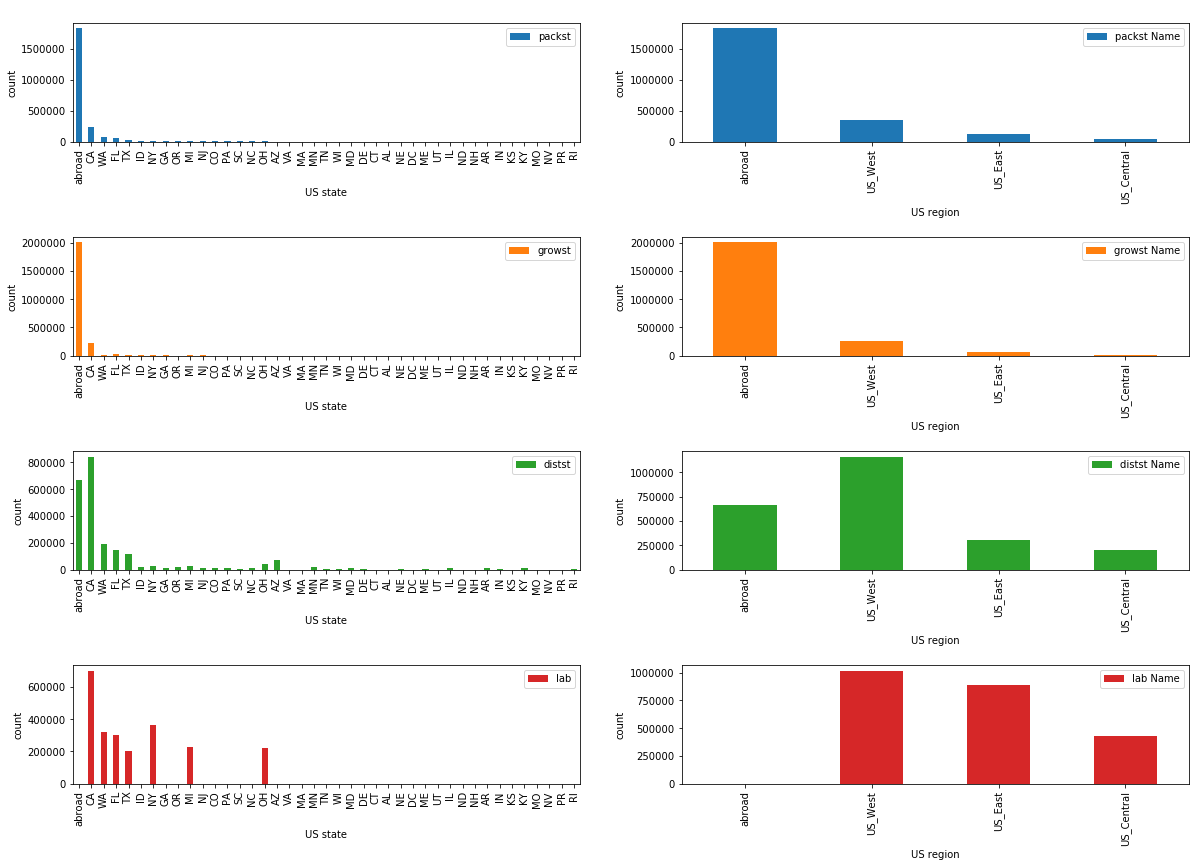

In [111]:
# Plot the dataset in bar plots by US staet and US region respectively

fig, ax = plt.subplots(4,2,figsize=(20,14))
axes1 = [ax[0,0], ax[1,0], ax[2,0], ax[3,0]]
axes2 = [ax[0,1], ax[1,1], ax[2,1], ax[3,1]]

cols_pdg_name = ['packst Name','growst Name','distst Name', 'lab Name']
subplots1 = sr3_wonan_pdg.sort_values(by='packst', ascending=False).plot(kind='bar',subplots=True,legend=True, 
                                                                         title= [' ',' ',' ',' '], figsize=(12,8), ax=axes1)
for item in list(subplots1):
    item.set_xlabel('US state')
    item.set_ylabel('count')      

subplots2 = sr3_wonan_pdg_name.sort_values(by='packst Name', ascending=False).plot(kind='bar',subplots=True, 
                                                                          title= [' ',' ',' ',' '], figsize=(12,8), ax=axes2)

for item in list(subplots2):
    item.set_xlabel('US region')
    item.set_ylabel('count')   

plt.subplots_adjust(wspace=0.2, hspace=0.8) 
plt.show()

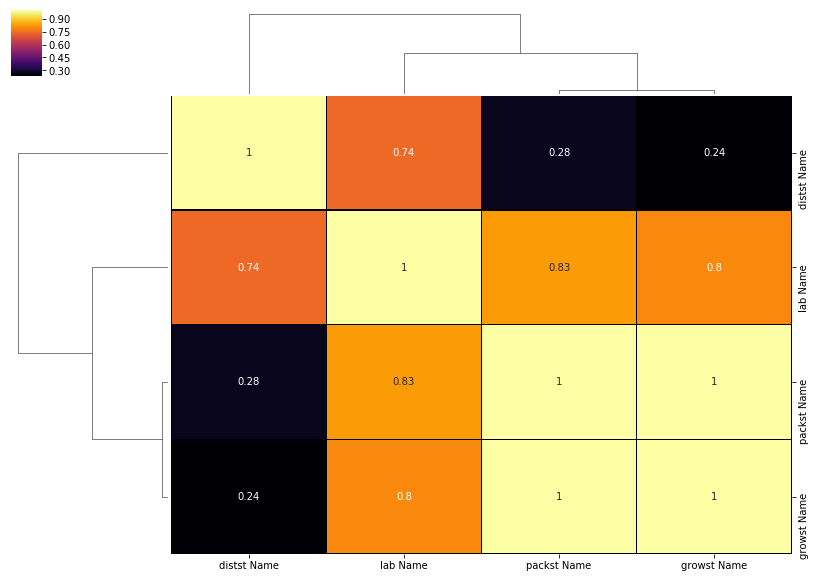

In [112]:
## Check if there is any correlation, between packing, distribution, grower and lab for US region
sns.clustermap(sr3_wonan[col_pdg_name].apply(pd.Series.value_counts).corr(),annot=True,cmap='inferno',linecolor='black',lw=0.5,figsize=(14,10))
plt.show()

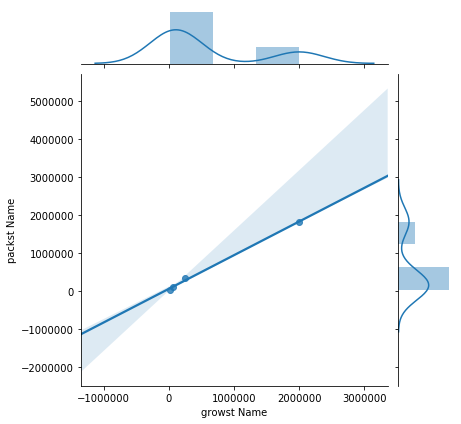

In [113]:
'''
Plot 'packst' and 'growst' in jointplot and see if there is any correlations for US region
'''
sns.jointplot(data=sr3_wonan,
              x=sr3_wonan_pdg_name['growst Name'],
              y=sr3_wonan_pdg_name['packst Name'],
              kind='reg',
#              xlim=[0,5000],
#              ylim=[0,5000],
             )
plt.show()

> **Remark**:
<br> - There is a strong correlation between the columns `growsth` and `packst`, which make sense; most of the time goods are packed where they are growed. One of these columns can be deleted. 

In [114]:
'''
The columns 'source_id', 'annotate', 'quantitative' display none value, replaced them by 'Unknown'
'''
cols_id = ['source_id','annotate','quantitate', 'confmethod','variety'] # Variety already replaced but here for being gathered in table format

sr3_wonan[cols_id] = sr3_wonan[cols_id].replace(' ', 'Unknown')
sr3_wonan[cols_id] = sr3_wonan[cols_id].replace('', 'Unknown')

In [115]:
# % of unknown values in the columns 'source_id', 'annotate', 'quantitative'

col_unknown = []
length_unknown = []
for c in cols_id:
    length_unknown.append(100*len(sr3_wonan.loc[sr3_wonan[c]=='Unknown',])/len(sr3_wonan))
    col_unknown.append(c)

col_unknown = pd.DataFrame(col_unknown, columns=['Columns wih unknown values'])
length_unknown=pd.DataFrame(length_unknown, columns=['% of unknown values'] )

together_unknown = pd.concat([col_unknown,length_unknown], axis=1)
together_unknown.round(2)

,Columns wih unknown values,% of unknown values
0,source_id,82.36
1,annotate,99.79
2,quantitate,99.91
3,confmethod,98.34
4,variety,29.96


> **Remark**:
<br> - These columns display a huge % of unknown values, either these columns can be deleted - except variety or we can incorporate the unknown values in the encoding process.

In [116]:
'''
The columns 'confmethod', 'quantitate' and 'mean' 
display very few values for one category that can be 
redistributed according to their frequencies
The column 'claim' displays very few values in 'pp' but since 
it is an important information as being pesticide free, it has been decided to keep it
'''
print(sr3_wonan['confmethod'].value_counts(normalize=True))
print('-'*50)
print(sr3_wonan['quantitate'].value_counts(normalize=True))
print('-'*50)
print(sr3_wonan['mean'].value_counts(normalize=True))
print('-'*50)
print(sr3_wonan['claim'].value_counts(normalize=True))
print('-'*50)

Unknown    0.983397
LU         0.011984
GT         0.004590
MO         0.000029
Name: confmethod, dtype: float64
--------------------------------------------------
Unknown    0.999137
P          0.000772
E          0.000090
Name: quantitate, dtype: float64
--------------------------------------------------
ND    0.953146
NP    0.030251
O     0.016443
R     0.000160
Name: mean, dtype: float64
--------------------------------------------------
NC    0.954954
PO    0.034426
OT    0.010272
PP    0.000348
Name: claim, dtype: float64
--------------------------------------------------


In [117]:
'''
From the columns above the few values ['MO','E','R'] can be
redistributed according to their frequencies
'''
col_dist = ['confmethod','quantitate','mean']
items_dist = ['MO','E','R']

for item, col in zip (items_dist,col_dist):
    sr3_wonan.loc[sr3_wonan[col]==item, col] = np.nan
    replacedvalues_freq(sr3_wonan, col)
    

In [118]:
print(sr3_wonan['confmethod'].value_counts(normalize=True))
print('-'*50)
print(sr3_wonan['quantitate'].value_counts(normalize=True))
print('-'*50)
print(sr3_wonan['mean'].value_counts(normalize=True))
print('-'*50)
print(sr3_wonan['claim'].value_counts(normalize=True))
print('-'*50)

Unknown    0.983425
LU         0.011985
GT         0.004590
Name: confmethod, dtype: float64
--------------------------------------------------
Unknown    0.999228
P          0.000772
Name: quantitate, dtype: float64
--------------------------------------------------
ND    0.953299
NP    0.030255
O     0.016446
Name: mean, dtype: float64
--------------------------------------------------
NC    0.954954
PO    0.034426
OT    0.010272
PP    0.000348
Name: claim, dtype: float64
--------------------------------------------------


In [119]:
stat(sr3_wonan.select_dtypes(exclude=np.number))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333911 entries, 0 to 2333910
Data columns (total 27 columns):
month                 object
site                  object
commod                object
source_id             object
variety               object
disttype              object
commtype              object
claim                 object
growst                object
packst                object
distst                object
lab                   object
pestcode              object
testclass             object
confmethod            object
annotate              object
quantitate            object
mean                  object
extract               object
determin              object
state_country Name    object
state_region Name     object
times                 object
packst Name           object
growst Name           object
distst Name           object
lab Name              object
dtypes: object(27)
memory usage: 578.6+ MB
--------------------------------------------------
Number of 

,month,site,commod,source_id,variety,disttype,commtype,claim,growst,packst,...,mean,extract,determin,state_country Name,state_region Name,times,packst Name,growst Name,distst Name,lab Name
count,2333911,2333911,2333911,2333911,2333911,2333911,2333911,2333911,2333911,2333911,...,2333911,2333911,2333911,2333911,2333911,2333911,2333911,2333911,2333911,2333911
unique,12,312,20,13,1260,5,3,4,30,33,...,3,2,5,28,9,142,4,4,4,3
top,05,0419,ST,Unknown,Unknown,D,FR,NC,abroad,abroad,...,ND,805,52,California,US_East,08.09.15,abroad,abroad,US_West,US_West
freq,222032,64853,298247,1922324,699144,1074424,2185814,2228778,2000811,1831674,...,2224916,2300206,1164034,396860,811502,47483,1831674,2000811,1161900,1019431


#### 2.11.5 Check Collinearities/Correlation Between Target and the Remaining Numerocal Columns

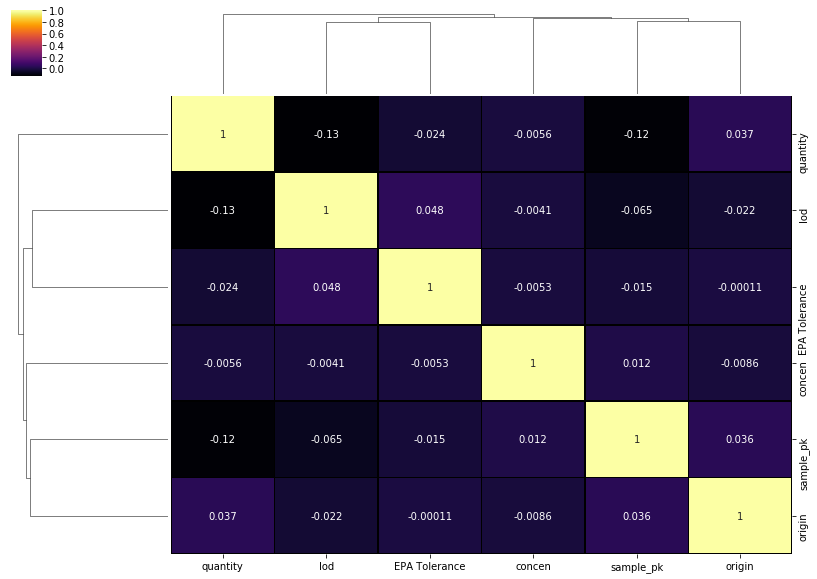

In [120]:
# Check the strenght of linear correlation between the numerical columns
sns.clustermap(sr3_wonan[num_cols].corr(),annot=True,cmap='inferno',linecolor='black',lw=0.5,figsize=(14,10))
plt.show()

> **Remarks**: 
<br> - There is no collinearity between the numerical columns, all of them can be kept for machine learning models.
<br> - There is no strong correlation between the target column `concen` and the other columns.

In [121]:
# Before removing the last columns, make a copy
sr4_wonan = sr3_wonan.copy()

In [122]:
'''
# Drop remain useless columns based on the last EDA analysis
'''

last_dropped_cols = ['sample_pk', 'origin', 'site', 'source_id', 'growst', 'packst', 'distst', 'lab', 
                     'growst Name', 'quantitate', 'state_country Name', 'times', 'variety', 'pestcode',
                      'claim','confmethod','annotate', 'extract',  
                     'commtype', 'mean']
#'pestcode'
for colo in last_dropped_cols:
    if colo not in sr4_wonan.columns:
        print('the column', colo, 'has been already deleted')
    else:   
        sr4_wonan.drop(columns=[colo],axis=1, inplace=True)
        
print(sr4_wonan.shape)
sr4_wonan.head()

(2333911, 13)


,month,commod,disttype,quantity,testclass,concen,lod,determin,EPA Tolerance,state_region Name,packst Name,distst Name,lab Name
0,01,AP,H,12.0,A,0.0,0.0030,35,0.05,US_West,abroad,US_West,US_West
1,01,AP,H,12.0,C,0.0,0.0050,52,0.00,US_West,abroad,US_West,US_West
2,01,AP,H,12.0,A,0.0,0.0100,35,0.05,US_West,abroad,US_West,US_West
3,01,AP,H,12.0,A,0.0,0.0015,52,0.00,US_West,abroad,US_West,US_West
4,01,AP,H,12.0,A,0.0,0.0100,35,0.05,US_West,abroad,US_West,US_West


> **Remarks**:
<br> - The columns like, for example, `confmethod`, `annotate`, `extract`, `commtype`,... have been removed based on the EDA above, i.e. displaying either very few categories or with one category almost at 100% or having too many "unknown“ values.
<br> - The two big sets of columns `variety` and `pestcodes` have been tested in different option samplings (option 1 and option 3- row 61), showing that the column `variety` did not display any added values in the results of the ML models and can be removed. 
<br> - In contrast, the column `pestcode` acts as a subcategory from `testclass` and might give some granularity to the models by giving small improvements in terms of results. Nevertheless, it has been decided to remove in order keep a reasonable trade-off between speed and accuracy, especially for the time-consuming model such as k-NN.

In [123]:
'''
Last check if some undesriable characters remain in the columns
'''
col_list_exotic = []
nunique_list_exotic = []
top_values_exotic = []
frequencies_exotic =[]
frequencies_exotic_percent = []

length = sr4_wonan.shape[0]
N=10

for c in sr4_wonan.columns:
    st=sr4_wonan.loc[(sr4_wonan[c]==np.nan) | (sr4_wonan[c]=='nan') | (sr4_wonan[c]=='NaN') | (sr4_wonan[c]=='NAN') | 
                     (sr4_wonan[c]=='Unknown') | (sr4_wonan[c]=='unknown') | (sr4_wonan[c]=='')| (sr4_wonan[c]=='')]
    
    if st[c].nunique()>0: #add to the table if >0 otherwise skipt it
        
        col_list_exotic.append(c)
        nunique_list_exotic.append(st[c].nunique())
        top_values_exotic.append(list(pd.value_counts(st[c]).index[0:N]))
        frequencies_exotic.append(list(pd.value_counts(st[c]).values[0:N]))
    
        results_exotic = pd.DataFrame({'Feature_Nominal_exotic':col_list_exotic,
                      'N_unique_Nominal':nunique_list_exotic,
                      'Top_values_Nominal':top_values_exotic,
                      'Frequency_Nominal':frequencies_exotic})
                     
results_exotic

/Users/jeromeaubry/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,Feature_Nominal_exotic,N_unique_Nominal,Top_values_Nominal,Frequency_Nominal
0,state_region Name,1,[Unknown],[21340]


In [124]:
# Last check if there is remaining NANs
stat(sr4_wonan)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333911 entries, 0 to 2333910
Data columns (total 13 columns):
month                object
commod               object
disttype             object
quantity             float64
testclass            object
concen               float64
lod                  float64
determin             object
EPA Tolerance        float64
state_region Name    object
packst Name          object
distst Name          object
lab Name             object
dtypes: float64(4), object(9)
memory usage: 249.3+ MB
--------------------------------------------------
Number of Os: 4399642
--------------------------------------------------
Column                 no NANs
-----------------  -----------
month              2.33391e+06
commod             2.33391e+06
disttype           2.33391e+06
quantity           2.33391e+06
testclass          2.33391e+06
concen             2.33391e+06
lod                2.33391e+06
determin           2.33391e+06
EPA Tolerance      2.33391e+06


,quantity,concen,lod,EPA Tolerance
count,2.333911e+06,2.333911e+06,2.333911e+06,2.333911e+06
mean,6.947699e+00,3.563100e-03,1.325073e-02,4.023632e-01
std,7.223800e+00,8.482975e-02,3.503929e-02,1.367352e+00
min,0.000000e+00,0.000000e+00,1.000000e-03,0.000000e+00
25%,0.000000e+00,0.000000e+00,2.500000e-03,0.000000e+00
50%,7.000000e+00,0.000000e+00,5.000000e-03,1.000000e-02
75%,1.200000e+01,0.000000e+00,1.000000e-02,1.000000e-01
max,6.200000e+01,1.600000e+01,5.000000e-01,1.600000e+01


> **Remark**: 
<br> No remaining NANs values are observed and the data are ready for being transformed for the ML models

In [125]:
sortout_topvalues(sr4_wonan, 10)

130it [00:04, 31.88it/s]                         


,Feature_Nominal,N_unique_Nominal,Top_values_Nominal,Frequency_Nominal
0,month,12,"[05, 06, 08, 07, 09, 03, 02, 04, 01, 11]","[222032, 209806, 208954, 208319, 198787, 19572..."
1,commod,20,"[ST, NE, AP, SP, OG, CB, TO, PO, GB, GR]","[298247, 243049, 154136, 152681, 147703, 14717..."
2,disttype,5,"[D, R, T, H, L]","[1074424, 454881, 427319, 272630, 104657]"
3,quantity,49,"[0.0, 10.0, 12.0, 11.0, 8.0, 9.0, 13.0, 7.0, 1...","[972701, 208711, 137232, 107654, 91874, 89505,..."
4,testclass,20,"[A, C, F, I, O, E, L, G, R, V]","[713955, 484136, 235929, 221765, 172448, 16703..."
5,concen,2582,"[0.0, 0.002, 0.011, 0.01, 0.012, 0.005, 0.013,...","[2295160, 1692, 646, 636, 592, 566, 546, 509, ..."
6,lod,126,"[0.005, 0.01, 0.0025, 0.001, 0.02, 0.002, 0.00...","[494977, 375053, 253050, 243297, 117663, 10493..."
7,determin,5,"[52, 35, 64, 07, 72]","[1164034, 862804, 260065, 37558, 9450]"
8,EPA Tolerance,31,"[0.0, 0.05, 0.1, 0.2, 2.0, 1.0, 0.02, 0.5, 0.0...","[1131781, 224049, 183869, 118560, 90495, 87329..."
9,state_region Name,9,"[US_East, US_West, America (wo US), US_Central...","[811502, 568172, 498061, 403068, 21340, 12132,..."


#### 2.11.6 Remaining Features vs. Target 

In [126]:
# All columns
print('-'*80)
print('Number of total columns of dataset:{}'.format(len(sr4_wonan.columns)))
print(sr4_wonan.columns)

print('-'*80)
# Remaining numerical columns
print('Number of numerical columns:{}'.format(len(sr4_wonan.select_dtypes(np.number).columns)))
print(sr4_wonan.select_dtypes(np.number).columns)
print('-'*80)
      
# Remaining non-numerical columns
print('Number of non-numerical columns:{}'.format(len(sr4_wonan.select_dtypes(exclude=np.number).columns)))
print(sr4_wonan.select_dtypes(exclude=np.number).columns)
print('-'*80)

--------------------------------------------------------------------------------
Number of total columns of dataset:13
Index(['month', 'commod', 'disttype', 'quantity', 'testclass', 'concen', 'lod',
       'determin', 'EPA Tolerance', 'state_region Name', 'packst Name',
       'distst Name', 'lab Name'],
      dtype='object')
--------------------------------------------------------------------------------
Number of numerical columns:4
Index(['quantity', 'concen', 'lod', 'EPA Tolerance'], dtype='object')
--------------------------------------------------------------------------------
Number of non-numerical columns:9
Index(['month', 'commod', 'disttype', 'testclass', 'determin',
       'state_region Name', 'packst Name', 'distst Name', 'lab Name'],
      dtype='object')
--------------------------------------------------------------------------------


In [127]:
'''
If existing remove the catergory with few values for the big non-numerical columns
variety', 'pestcode', 'testclass', 'site'
'''

long_cols = ['variety', 'pestcode', 'testclass', 'site']

index_fewvalues = []


for cols_long in long_cols:
    if cols_long not in sr4_wonan:
        print('the column', cols_long, 'has been already deleted')
    else:   
        counts = sr4_wonan[cols_long].value_counts()
        sr4_wonan_fewvalues = sr4_wonan.loc[sr4_wonan[cols_long].isin(counts.index[counts < 3]),:]
        index_fewvalues.extend(sr4_wonan_fewvalues.index)
    
index_fewvalues

print('-'*50)
print('lenght of the rows with few :',len(index_fewvalues))
print('lenght of the outliers rows:',len(sr4_wonan))
print('% of outlier rows over the whole data: {:.2f} %'.format(100*len(index_fewvalues)/len(sr4_wonan)))
print('-'*50)

the column variety has been already deleted
the column pestcode has been already deleted
the column site has been already deleted
--------------------------------------------------
lenght of the rows with few : 0
lenght of the outliers rows: 2333911
% of outlier rows over the whole data: 0.00 %
--------------------------------------------------


In [128]:
# Remove the outliers (3-97%) and few value if existing for the le big categorical columns ('variety, pestcode', 'site', 'testclass')
sr4_wonan = sr4_wonan.loc[sr4_wonan.index.difference(index_outliers),:]
sr4_wonan = sr4_wonan.loc[sr4_wonan.index.difference(index_fewvalues),:]

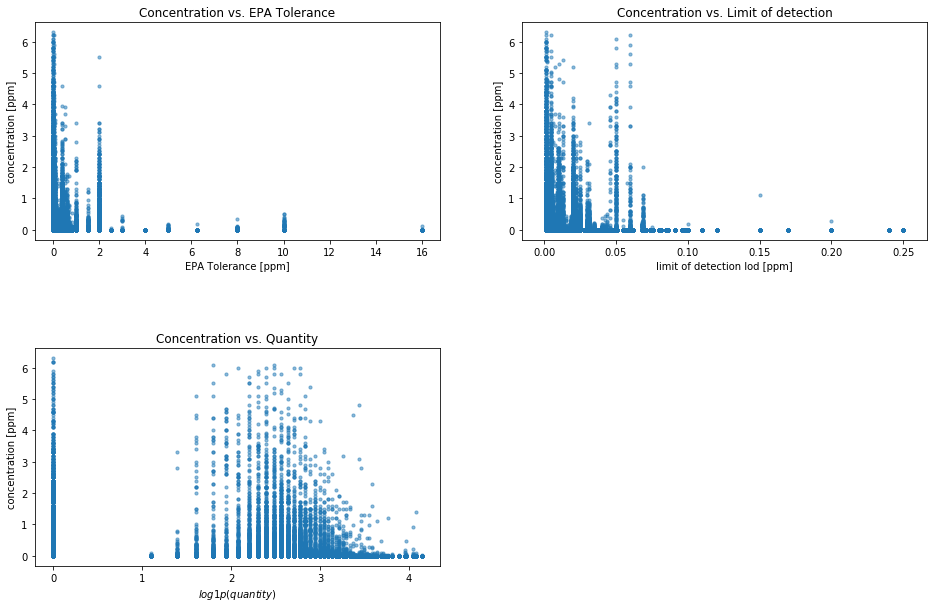

In [129]:
'''
Plot 'lod', 'EPA Tolerance', 'quantity', 'origin' vs target 'concen' 
in scatter plot and display data distribution
'''
fig, ax = plt.subplots(2,2, figsize=(16,10))

ax[0,0].scatter(sr4_wonan['EPA Tolerance'],sr4_wonan['concen'], alpha=0.5, s=10)
ax[0,0].set_title('Concentration vs. EPA Tolerance')
ax[0,0].set_xlabel('EPA Tolerance [ppm]')
ax[0,0].set_ylabel('concentration [ppm]')

ax[0,1].scatter(sr4_wonan['lod'],sr4_wonan['concen'], alpha=0.5, s=10)
ax[0,1].set_title('Concentration vs. Limit of detection')
ax[0,1].set_xlabel('limit of detection lod [ppm]')
ax[0,1].set_ylabel('concentration [ppm]')

ax[1,0].scatter(np.log1p(sr4_wonan['quantity']),sr4_wonan['concen'], alpha=0.5, s=10)
ax[1,0].set_title('Concentration vs. Quantity')
ax[1,0].set_xlabel('$log1p(quantity)$')
ax[1,0].set_ylabel('concentration [ppm]')

ax[1,1].set_axis_off()

plt.subplots_adjust(wspace=0.2, hspace=0.5) 
plt.show()

In [130]:
last_nonnums_cols = sr4_wonan.select_dtypes(exclude=np.number).columns
last_nonnums_cols_len = len(last_nonnums_cols )
print(last_nonnums_cols_len)
last_nonnums_cols

9


Index(['month', 'commod', 'disttype', 'testclass', 'determin',
       'state_region Name', 'packst Name', 'distst Name', 'lab Name'],
      dtype='object')

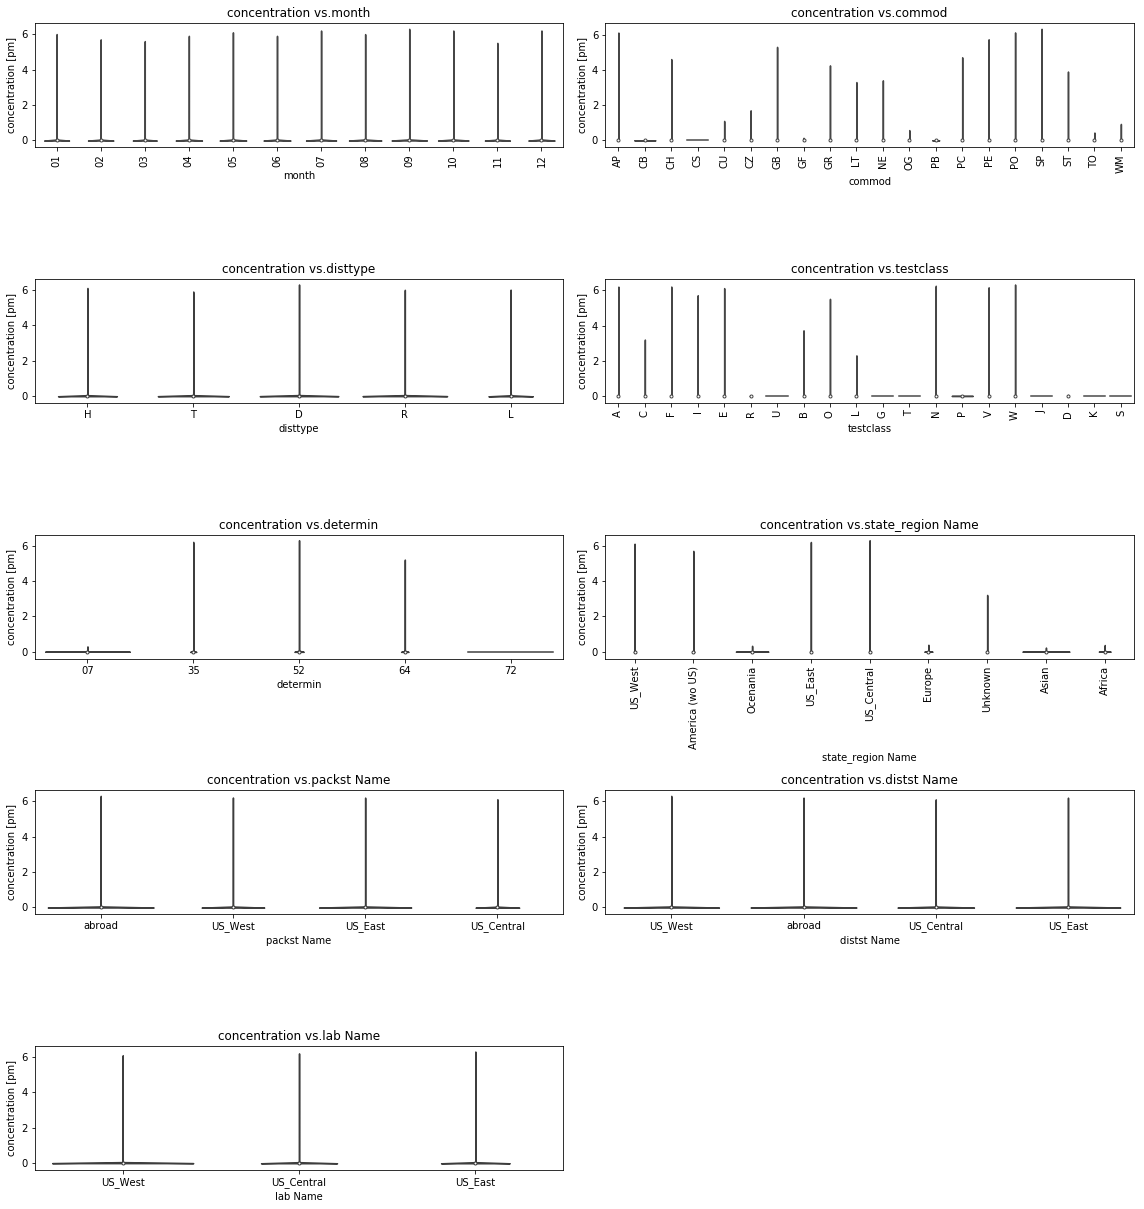

In [131]:
# Plot the remaining 
fig = plt.figure(figsize=(16,20))

for c, i in zip(last_nonnums_cols, range(last_nonnums_cols_len)):
    axes = fig.add_subplot(6,2,i+1)
    
    if sr4_wonan[c].nunique() > 30.: # Plot the 15 most highes values for 'site', 'variety', 'testclass', which are very long
        sr4_wonan_concen_selected = sr4_wonan.sort_values(by='concen', ascending=False).head(15) # Take the 15 most highes values of column concen
        sns.violinplot(x=sr4_wonan_concen_selected[c], y=sr4_wonan_concen_selected['concen'],color='b',alpha=0.5,edgecolor='black')
    
    else:
        sns.violinplot(x=sr4_wonan[c], y=sr4_wonan['concen'], ax=axes)
    
    if sr4_wonan[c].nunique() > 5.: 
        axes.tick_params(axis='x', rotation=90)
    
    axes.set_ylabel('concentration [pm]')
    axes.set_title('concentration vs.' + str(c))

fig.tight_layout()
plt.show()


**Remarks**:
<br> - The numerical data does not show any direct correlation with the target
<br> - The categorical data display important outliers spreading the violon plots while the majority of the points are around 0.

#### 2.11.7 Data Transformation for ML Models

In [132]:
'''
Function applying:
- Eliminating the outliers based on 3%/97% criterion (best choices afeter several runs)
- 2D encoding on non numerical columns
- feature engineering on numerical columns
''' 

def transform_columns(df):    
    
    # A. Clean outliers based on EDA, based on visual approach decide to clean <5% and >95% 
    
    #df = df.loc[df.index.difference(index_outliers),:] # already done in row 173 for visualizing the features
    print('outliers')
    print('-'*50)
    print('lenght of the outliers rows:',len(index_outliers))
    print('lenght of dataset rows:',len(df))
    print('% of outlier rows over the whole data: {:.2f} %'.format(100*len(index_outliers)/len(df)))
    print('-'*50)
    
    # B. Apply Feature Engineering to numerical values based on EPA
    
    #.B.1. Apply log1p to the numerical columns based on EPA, here column 'quantity'
    log_numcols = ['quantity']
    for c in log_numcols:
        df[c] = np.log1p(df[c])

    # C. Non numerical values 
    
    # C.1 Remove the low values if exsisting for big columns
    
    #df = df.loc[df.index.difference(index_fewvalues),:] # already done in row 173 for visualizing the features
    print('few values in big columns')
    print('-'*50)
    print('lenght of the rows with few values:',len(index_fewvalues))
    print('lenght of dataset rows:',len(df))
    print('% of rows with few values over the whole data: {:.2f} %'.format(100*len(index_fewvalues)/len(df)))
    print('-'*50)

    # C.2 Apply 1D encoding in non numerical column based on EDA     
    #for col in last_nonnums_cols:
    #    val_old = df[col].unique()
    #    for item, i in zip(val_old,range(len(non_cols_2D):
    #            df.loc[df[col] == item, col] = i
    
    
    #for c in last_nonnums_cols:
    #     df[[c]]= OrdinalEncoder().fit_transform(df[[c]])
    
    # C.3. Apply 2D encoding in non numerical column based on EDA  
    df = pd.get_dummies(df, columns=last_nonnums_cols, drop_first=False) # Take all the columns
                                         
    return df

> **Remark**:
<br> - It has been decided to one-hot encoding the categorical columns as displaying best results with the ML models compared to the 1D encoding.

In [133]:
# Apply the transformation
sr5_wonan = transform_columns(sr4_wonan)

outliers
--------------------------------------------------
lenght of the outliers rows: 7616
lenght of dataset rows: 2326295
% of outlier rows over the whole data: 0.33 %
--------------------------------------------------
few values in big columns
--------------------------------------------------
lenght of the rows with few values: 0
lenght of dataset rows: 2326295
% of rows with few values over the whole data: 0.00 %
--------------------------------------------------


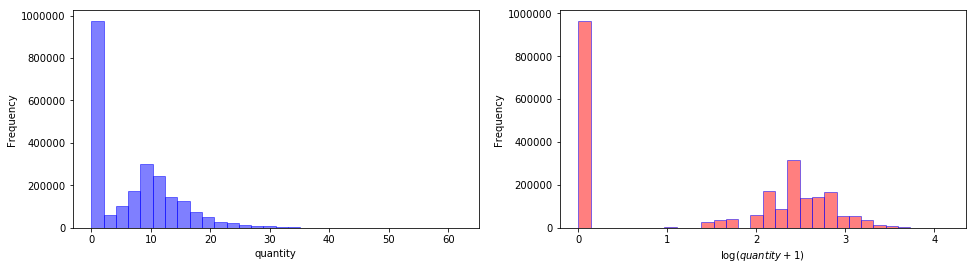

In [134]:
# Before/After applying the feature engineering on column 'quantity' as check
fig, ax = plt.subplots(1,2, figsize=(16,4))

sr3_wonan['quantity'].plot(kind='hist', alpha=0.5, color='b', bins=30, edgecolor='b', ax=ax[0])
sr5_wonan['quantity'].plot(kind='hist', alpha=0.5, color='r', bins=30, edgecolor='b', ax=ax[1])

ax[0].set_xlabel('quantity')
ax[1].set_xlabel(r'$\log(quantity +1)$')
plt.show()

In [135]:
# Check the changes in shape before/after applying the tranformation
print(sr4_wonan.shape)
print(sr5_wonan.shape)

(2326295, 13)
(2326295, 86)


#### 2.11.8 Save as npz 

In [136]:
# Define the X and y target
X = sr5_wonan.drop(['concen'], axis=1)
y = sr5_wonan['concen']

In [137]:
'''
Check what are the most important columns from X that correlate the most with the target Y=df['concen']
'''  
sr5_wonan_simulation = sr5_wonan[X.columns[selected_bestcols(X,y,10)]]
sr5_wonan_simulation.head()

,testclass_V,testclass_N,commod_SP,testclass_C,testclass_B,lab Name_US_West,commod_PE,commod_PO,lab Name_US_East,testclass_E
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0


> **Remarks**:
<br> - By down-selecting the 10 most columns that correlate the most with the target `concen`, as expected the columns dedicated to pesticides, also  some fruits/vegetables like `spinard` are the strongest correlated ones.
<br> - However, as seen during the project 3 and tested here, the best option in terms of results was to take all the features leading to a slightly better result than only take the 10 most dominant ones.

In [138]:
# Select the first 10 columns
# X = sr5_wonan_simulation.iloc[:,:10]

In [139]:
# Before saving in npz format, transform the train values in numpy format
X_array = np.array(X)
col_names_array = np.array(sr5_wonan.columns)
y_array = np.array(y)

In [140]:
# Save data in the following folders
path_main_save = '/Users/jeromeaubry/Chap5.1-Proposal-Capstone/Data/'
path_secondary_save = 'US_Pesticide/2015PDPDatabase/SaveModels/'

path_save = os.path.join(path_main_save,path_secondary_save)
os.chdir(path_save)
os.getcwd()

'/Users/jeromeaubry/Chap5.1-Proposal-Capstone/Data/US_Pesticide/2015PDPDatabase/SaveModels'

In [141]:
# Save the data in npz format for X and y data 

np.savez('data_pesticides_option2_EDA_1', data = X_array, target = y_array, labels = col_names_array) #4.7MB
#sr5_wonan.to_csv('data_pesticdes.csv', encoding='utf-8', float_format='%.2f', index=False) #6.2MB

# option 1: Sample data: 38751 column 'concen' and take only non zeros values --> Proposal
# option 2: All the data 2M (100% of the dataset) --> EDA 
# option 3: Sample data: around 100'000 - 5% of the dataset (mix zeros and non zeros) --> ML Models

In [142]:
# Check the array of the transformed data
X.shape

(2326295, 85)

In [143]:
# Release memory by cleaning the different dataset from  the EDA if necessary

datamem = str(input("Do you want to release the memory by cleaning the dataset?: "))

if datamem == 'yes':
    del [results,samples, sr,sr2, sr2_wonan, sr3_wonan, sr4_wonan, sr5_wonan]

    gc.collect()

    results = pd.DataFrame()
    samples = pd.DataFrame()
    sr = pd.DataFrame()
    sr2 = pd.DataFrame()
    sr2_wonan = pd.DataFrame()
    sr3_wonan = pd.DataFrame()
    sr4_wonan = pd.DataFrame()
    sr5_wonan = pd.DataFrame()

Do you want to release the memory by cleaning the dataset?:  no
